This notebook is the primary notebook for the project where we bring the final code together.

#Install packages and import libraries

In [1]:
pip install stargazer

In [2]:
%load_ext rpy2.ipython

In [3]:
%%capture
%%R
install.packages("bacondecomp")

In [4]:
%%capture
%%R
#https://stackoverflow.com/questions/24094476/python-pandas-to-r-dataframe
install.packages("feather")

In [5]:
%%capture
%%R
# This cell takes about 9 minutes to run
install.packages("did")

In [7]:
%%capture
%%R
devtools::install_github("kylebutts/didimputation")

In [8]:
%%R
library(tidyverse)
#> ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
#> ✓ ggplot2 3.3.5     ✓ purrr   0.3.4
#> ✓ tibble  3.1.3     ✓ dplyr   1.0.7
#> ✓ tidyr   1.1.3     ✓ stringr 1.4.0
#> ✓ readr   2.0.0     ✓ forcats 0.5.1
#> ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
#> x dplyr::filter() masks stats::filter()
#> x dplyr::lag()    masks stats::lag()
library(didimputation)
#> Loading required package: fixest

library(fixest)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: fixest



In [9]:
pip install geopandas

In [10]:
pip install shap

In [11]:
pip install git+https://github.com/microsoft/dowhy.git

  Cloning https://github.com/microsoft/dowhy.git to /tmp/pip-req-build-ilx94rcr
  Running command git clone -q https://github.com/microsoft/dowhy.git /tmp/pip-req-build-ilx94rcr


In [12]:
pip install econml

In [13]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p
from datetime import datetime
import datetime
import math
from itertools import cycle
from google.colab import files
from stargazer.stargazer import Stargazer
import shap
import plotly.express as px
import altair as alt
import geopandas as gpd
from shapely import affinity
from shapely.geometry import mapping, shape
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import LogColorMapper, FixedTicker, ColorBar, GeoJSONDataSource, HoverTool, Slider, CustomJS
from bokeh.palettes import Blues7 as palette
from bokeh.plotting import figure, show
from sklearn.datasets import make_regression
from dowhy import CausalModel
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
pd.set_option('display.max_columns', None) #uncomment if you want to see all the columns of a df when you print it
# pd.set_option('display.max_rows', None) #uncomment if you want to see all the rows of a df when you print it
from sklearn.model_selection import GridSearchCV
from econml.dml import DML, LinearDML, CausalForestDML, NonParamDML
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from econml.cate_interpreter import SingleTreeCateInterpreter


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Upload data sets for law, demographics, maps and CSA

In [14]:
uploaded = files.upload()

Saving cb_2018_us_state_20m.cpg to cb_2018_us_state_20m (1).cpg
Saving cb_2018_us_state_20m.dbf to cb_2018_us_state_20m (1).dbf
Saving cb_2018_us_state_20m.prj to cb_2018_us_state_20m (1).prj
Saving cb_2018_us_state_20m.shp to cb_2018_us_state_20m (1).shp
Saving cb_2018_us_state_20m.shp.ea.iso.xml to cb_2018_us_state_20m.shp.ea.iso (1).xml
Saving cb_2018_us_state_20m.shp.iso.xml to cb_2018_us_state_20m.shp.iso (1).xml
Saving cb_2018_us_state_20m.shx to cb_2018_us_state_20m (1).shx
Saving Demographics_state_v2.xlsx to Demographics_state_v2 (1).xlsx
Saving legaldata.csv to legaldata (1).csv
Saving mhi_state_lvl.xlsx to mhi_state_lvl (1).xlsx
Saving Population_state_lvl.xlsx to Population_state_lvl (1).xlsx
Saving sample_csa_data.csv to sample_csa_data (1).csv
Saving sample_data_capstone.csv to sample_data_capstone (1).csv
Saving sample_missing_reports.csv to sample_missing_reports (1).csv
Saving Unemployment_rate_state_lvl.xlsx to Unemployment_rate_state_lvl (1).xlsx


In [15]:
c = pd.read_csv('legaldata.csv')

In [16]:
demographic_df = pd.read_excel('Demographics_state_v2.xlsx')

In [17]:
csa_df = pd.read_csv('sample_csa_data.csv')

#Clean up and format legal data

In [18]:
c = c.iloc[:,:-1]

In [19]:
columns = ['Effective Date','Screening Date Enacted','Criminalization Date Enacted']  #the columns that needed the date converted to datetime
for a in columns:
    c[a] = c[a].apply(lambda x: datetime.datetime.strptime(str(x), "%m-%y'").date() if "'" in str(x) else x) #convert string to datetime

In [20]:
c.replace('NAN',np.nan, inplace = True) #converting string NAN to np.nan
c['STATE'] = c['STATE'].str.replace('\r\n', '', regex=False)


In [21]:
c.dropna(axis=0, how='all', inplace = True) #dropping empty rows

In [22]:
newdf = pd.DataFrame(np.repeat(c.values, 15, axis=0)) #replicate each row 15 times 
newdf.columns = c.columns


In [23]:
seq = cycle([2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])
newdf['yrs'] = [next(seq) for count in range(newdf.shape[0])] #create a new column which is filled by iterating through 2005-2019 year range 

In [24]:
#little messy but the logic is check if value in row is a datetime (so not nan or a string)
#if datetime date comes after the year we are looking at currently
#convert all the corresponding values to 0

for x in range(0,len(newdf)):
    if isinstance(newdf['Effective Date'][x],datetime.date) == True:
        if (newdf['Effective Date'][x].year > newdf['yrs'][x]) == True:
            newdf.iloc[x,2:20] = 0 
        elif (newdf['Effective Date'][x].year == newdf['yrs'][x]) and (newdf['Effective Date'][x].month > 6):
            newdf.iloc[x,2:20] = 0
    if isinstance(newdf['Screening Date Enacted'][x],datetime.date) == True:
        if (newdf['Screening Date Enacted'][x].year >  newdf['yrs'][x]) == True:
            newdf.iloc[x,21] = 0
        elif (newdf['Screening Date Enacted'][x].year ==  newdf['yrs'][x]) and (newdf['Screening Date Enacted'][x].month > 6):
            newdf.iloc[x,21] = 0
    if isinstance(newdf['Criminalization Date Enacted'][x],datetime.date) == True:
        if (newdf['Criminalization Date Enacted'][x].year >  newdf['yrs'][x]) == True:
            newdf.iloc[x,23] = 0
        elif (newdf['Criminalization Date Enacted'][x].year ==  newdf['yrs'][x]) and (newdf['Criminalization Date Enacted'][x].month > 6):
            newdf.iloc[x,23] = 0
    if isinstance(newdf['Task Force Year Enacted'][x],str) == True:
        if (int(newdf['Task Force Year Enacted'][x]) >  newdf['yrs'][x]) == True:
            newdf.iloc[x,25] = 0
    if isinstance(newdf['Poster Year Enacted'][x],str) == True:
        if (int(newdf['Poster Year Enacted'][x]) >  newdf['yrs'][x]) == True:
            newdf.iloc[x,27] = 0



In [25]:
n = 15  #chunk row size
list_df = [newdf[i:i+n] for i in range(0,newdf.shape[0],n)] #chunking dataframe into smaller dataframes for each state

#Add data for trends

In [26]:
#my implementation of the "trend" columns in the Cunningham notebook. Pretty much just broke the dataframe into chunks, created a new column in each one which is the trend column
#and then appended the chunks back together to create the final dataframe
for i in range(0,len(list_df)):
    list_df[i][f'trend_{i}'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] 
    

trenddf = pd.DataFrame().append(list_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
#filling nan's with 0 for the trend columns

trenddf[list(trenddf.columns[30:])] = trenddf[list(trenddf.columns[30:])].fillna(0)

In [28]:
trenddf.drop(list(range(71,86)), axis = 0, inplace = True) #dropped overlapping rows from California

In [29]:
trenddf.drop(list(range(225,240)), axis = 0, inplace = True) #dropped overlapping rows from Illinois

In [30]:
trenddf.drop(list(range(253,268)), axis = 0, inplace = True) #dropped overlapping rows from Indiana

In [31]:
#dropped duplicate columns and renamed trend columns
trenddf['trend_4'] = trenddf['trend_4'] + trenddf['trend_5'] 
trenddf['trend_16'] = trenddf['trend_16'] + trenddf['trend_17']
trenddf.drop(columns = ['trend_5','trend_15','trend_17'], inplace = True)


In [32]:
d = dict(zip(trenddf.columns[30:], trenddf['STATE'].unique() + '_' + 'trend')) #dictionary to replace column trend numbers with state names
trenddf.rename(columns = d, inplace = True)

In [33]:
#add state ID
trenddf['sid'] = trenddf.groupby(['STATE']).ngroup()


In [34]:
trenddf.columns = trenddf.columns.str.strip().str.replace('\r\n', '', regex=False).str.replace(" ", "_")
trenddf.head()

STATE Year_Enacted Year_Binary Required Some/All_Staff PK  K Grade_1  \
0  Alabama        7-15'           0        0              0  0  0       0   
1  Alabama        7-15'           0        0              0  0  0       0   
2  Alabama        7-15'           0        0              0  0  0       0   
3  Alabama        7-15'           0        0              0  0  0       0   
4  Alabama        7-15'           0        0              0  0  0       0   

  Grade_2 Grade_3 Grade_4 Grade_5 Grade_6 Grade_7 Grade__8 Grade_9 Grade_10  \
0       0       0       0       0       0       0        0       0        0   
1       0       0       0       0       0       0        0       0        0   
2       0       0       0       0       0       0        0       0        0   
3       0       0       0       0       0       0        0       0        0   
4       0       0       0       0       0       0        0       0        0   

  Grade_11 Grade_12 Opt-Out Effective_Date Screening Screening_Date_Enacted  \
0        0        0       0     2015-06-01         0                    NaN   
1        0        0       0     2015-06-01         0                    NaN   
2        0        0       0     2015-06-01         0                    NaN   
3        0        0       0     2015-06-01         0                    NaN   
4        0        0       0     2015-06-01         0                    NaN   

  Criminalization Criminalization_Date_Enacted Task_Force  \
0               0                   2012-07-01          0   
1               0                   2012-07-01          0   
2               0                   2012-07-01          0   
3               0                   2012-07-01          0   
4               0                   2012-07-01          0   

  Task_Force_Year_Enacted Posters Poster_Year_Enacted   yrs  Alabama_trend  \
0                    2015       0                 NaN  2005            1.0   
1                    2015       0                 NaN  2006            2.0   
2                    2015       0                 NaN  2007            3.0   
3                    2015       0                 NaN  2008            4.0   
4                    2015       0                 NaN  2009            5.0   

   Alaska_trend  Arizona_trend  Arkansas_trend  California_trend  \
0           0.0            0.0             0.0               0.0   
1           0.0            0.0             0.0               0.0   
2           0.0            0.0             0.0               0.0   
3           0.0            0.0             0.0               0.0   
4           0.0            0.0             0.0               0.0   

   Colorado_trend  Connecticut_trend  Delaware_trend  \
0             0.0                0.0             0.0   
1             0.0                0.0             0.0   
2             0.0                0.0             0.0   
3             0.0                0.0             0.0   
4             0.0                0.0             0.0   

   District_of_Columbia_trend  Florida_trend  Georgia_trend  Hawaii_trend  \
0                         0.0            0.0            0.0           0.0   
1                         0.0            0.0            0.0           0.0   
2                         0.0            0.0            0.0           0.0   
3                         0.0            0.0            0.0           0.0   
4                         0.0            0.0            0.0           0.0   

   Idaho_trend  Illinois_trend  Indiana_trend  Iowa_trend  Kansas_trend  \
0          0.0             0.0            0.0         0.0           0.0   
1          0.0             0.0            0.0         0.0           0.0   
2          0.0             0.0            0.0         0.0           0.0   
3          0.0             0.0            0.0         0.0           0.0   
4          0.0             0.0            0.0         0.0           0.0   

   Kentucky_trend  Louisiana_trend  Maine_trend  Maryland_trend  \
0             0.0            

In [35]:
trenddf.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765 entries, 0 to 809
Data columns (total 82 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   STATE                         765 non-null    object 
 1   Year_Enacted                  510 non-null    object 
 2   Year_Binary                   765 non-null    object 
 3   Required                      765 non-null    object 
 4   Some/All_Staff                765 non-null    object 
 5   PK                            765 non-null    object 
 6   K                             765 non-null    object 
 7   Grade_1                       765 non-null    object 
 8   Grade_2                       765 non-null    object 
 9   Grade_3                       765 non-null    object 
 10  Grade_4                       765 non-null    object 
 11  Grade_5                       765 non-null    object 
 12  Grade_6                       765 non-null    object 
 13  Grade

# Clean and add demographic data

In [36]:
# drop unnamed column and rename variable to match with other datasets
demographic_df.drop(columns=['Unnamed: 0'], inplace=True)
demographic_df.rename(columns={'State':'STATE', 'Year':'yrs'}, inplace=True)
demographic_df['STATE'].replace({'D.C.':'District of Columbia'}, inplace = True)

# Add in missing DC data
dc_mean_pop = [567136,570681,574404,580236,592228,605226,619800, 634924,650581,662328,675400,685815,694906,701547,705749]
dc_unemp_rate = [6.4,5.8,5.5,6.5,9.3,9.4,10.2,9.0,8.5,7.8,6.9,6.1,6.1,5.6,5.3]
demographic_df.iloc[120:135,3] = dc_mean_pop
demographic_df.iloc[120:135,4] = dc_unemp_rate

demographic_df

STATE   yrs  median_household_income      mean_pop  Unemployment_rate
0    Alabama  2005                    37150  4.786351e+06                4.5
1    Alabama  2006                    37952  4.786351e+06                4.0
2    Alabama  2007                    42212  4.786351e+06                4.0
3    Alabama  2008                    44476  4.786351e+06                5.7
4    Alabama  2009                    39980  4.786351e+06               11.0
..       ...   ...                      ...           ...                ...
760  Wyoming  2015                    60925  5.636397e+05                4.3
761  Wyoming  2016                    57829  5.636397e+05                5.3
762  Wyoming  2017                    59536  5.636397e+05                4.2
763  Wyoming  2018                    62539  5.636397e+05                4.1
764  Wyoming  2019                    66152  5.636397e+05                3.7

[765 rows x 5 columns]

In [37]:
# Check for missing values
are_there_nans = demographic_df.isnull().values.any()

if are_there_nans == True:
  for column in demographic_df.columns:
    print(column, demographic_df[column].isnull().sum())

In [38]:
# Open population data by state
pop = pd.read_excel('Population_state_lvl.xlsx',)
pop.rename(columns={'Area':'State'}, inplace=True)
pop = pop.set_index('State')

# Make a copy of the dataset (NOT averaged) for visualization
pop_not_avg = pop.copy()

# Reset the index
pop_not_avg.reset_index(inplace=True)

# Use stack to convert df to only 1 column 
pop_not_avg = pd.DataFrame(pop_not_avg.set_index('State').stack())

# Reset index, and fix column names
pop_not_avg.reset_index(inplace=True)
pop_not_avg.rename(columns={'State':'STATE', 'level_1':'yrs', 0:'pop'}, inplace=True)

pop_not_avg

STATE   yrs      pop
0    Alabama  2005  4569805
1    Alabama  2006  4628981
2    Alabama  2007  4672840
3    Alabama  2008  4718206
4    Alabama  2009  4757938
..       ...   ...      ...
760  Wyoming  2015   585613
761  Wyoming  2016   584215
762  Wyoming  2017   578931
763  Wyoming  2018   577601
764  Wyoming  2019   578759

[765 rows x 3 columns]

In [39]:
# Merge the demographic dataframe with the population not avg df
demographic_df = pop_not_avg.merge(demographic_df, on=['STATE', 'yrs'], how='left')
demographic_df

STATE   yrs      pop  median_household_income      mean_pop  \
0    Alabama  2005  4569805                    37150  4.786351e+06   
1    Alabama  2006  4628981                    37952  4.786351e+06   
2    Alabama  2007  4672840                    42212  4.786351e+06   
3    Alabama  2008  4718206                    44476  4.786351e+06   
4    Alabama  2009  4757938                    39980  4.786351e+06   
..       ...   ...      ...                      ...           ...   
760  Wyoming  2015   585613                    60925  5.636397e+05   
761  Wyoming  2016   584215                    57829  5.636397e+05   
762  Wyoming  2017   578931                    59536  5.636397e+05   
763  Wyoming  2018   577601                    62539  5.636397e+05   
764  Wyoming  2019   578759                    66152  5.636397e+05   

     Unemployment_rate  
0                  4.5  
1                  4.0  
2                  4.0  
3                  5.7  
4                 11.0  
..                 ...  
760                4.3  
761                5.3  
762                4.2  
763                4.1  
764                3.7  

[765 rows x 6 columns]

In [40]:
# Merge the demographic dataframe with the trend_df
demographic_and_trend_df = trenddf.merge(demographic_df, on=['STATE', 'yrs'], how='left')
demographic_and_trend_df

STATE Year_Enacted Year_Binary Required Some/All_Staff PK  K Grade_1  \
0    Alabama        7-15'           0        0              0  0  0       0   
1    Alabama        7-15'           0        0              0  0  0       0   
2    Alabama        7-15'           0        0              0  0  0       0   
3    Alabama        7-15'           0        0              0  0  0       0   
4    Alabama        7-15'           0        0              0  0  0       0   
..       ...          ...         ...      ...            ... .. ..     ...   
760  Wyoming        7-18'           0        0              0  0  0       0   
761  Wyoming        7-18'           0        0              0  0  0       0   
762  Wyoming        7-18'           0        0              0  0  0       0   
763  Wyoming        7-18'           0        0              0  0  0       0   
764  Wyoming        7-18'           1        0              0  0  0       0   

    Grade_2 Grade_3 Grade_4 Grade_5 Grade_6 Grade_7 Grade__8 Grade_9 Grade_10  \
0         0       0       0       0       0       0        0       0        0   
1         0       0       0       0       0       0        0       0        0   
2         0       0       0       0       0       0        0       0        0   
3         0       0       0       0       0       0        0       0        0   
4         0       0       0       0       0       0        0       0        0   
..      ...     ...     ...     ...     ...     ...      ...     ...      ...   
760       0       0       0       0       0       0        0       0        0   
761       0       0       0       0       0       0        0       0        0   
762       0       0       0       0       0       0        0       0        0   
763       0       0       0       0       0       0        0       0        0   
764       0       0       0       0       0       0        0       0        0   

    Grade_11 Grade_12 Opt-Out Effective_Date Screening Screening_Date_Enacted  \
0          0        0       0     2015-06-01         0                    NaN   
1          0        0       0     2015-06-01         0                    NaN   
2          0        0       0     2015-06-01         0                    NaN   
3          0        0       0     2015-06-01         0                    NaN   
4          0        0       0     2015-06-01         0                    NaN   
..       ...      ...     ...            ...       ...                    ...   
760        0        0       0     2018-07-01         0                    NaN   
761        0        0       0     2018-07-01         0                    NaN   
762        0        0       0     2018-07-01         0                    NaN   
763        0        0       0     2018-07-01         0                    NaN   
764        0        0       0     2018-07-01         0                    NaN   

    Criminalization Criminalization_Date_Enacted Task_Force  \
0                 0                   2012-07-01          0   
1                 0                   2012-07-01          0   
2                 0                   2012-07-01          0   
3                 0                   2012-07-01          0   
4                 0                   2012-07-01          0   
..              ...                          ...        ...   
760               1                   2011-07-01          0   
761               1                   2011-07-01          0   
762               1                   2011-07-01          0   
763               1                   2011-07-01          0   
764               1                   2011-07-01          0   

    Task_Force_Year_Enacted Posters Poster_Year_Enacted   yrs  Alabama_trend  \
0                      2015       0                 NaN  2005            1.0   
1                      2015       0                 NaN  2006            2.0   
2                      2015       0                 NaN  2007            3.0   
3                      2015       0

In [41]:
# Check for missing values
are_there_nans = demographic_and_trend_df.isnull().values.any()

if are_there_nans == True:
  for column in demographic_and_trend_df.columns:
    print(column, demographic_and_trend_df[column].isnull().sum())

STATE 0
Year_Enacted 255
Year_Binary 0
Required 0
Some/All_Staff 0
PK 0
K 0
Grade_1 0
Grade_2 0
Grade_3 0
Grade_4 0
Grade_5 0
Grade_6 0
Grade_7 0
Grade__8 0
Grade_9 0
Grade_10 0
Grade_11 0
Grade_12 0
Opt-Out 0
Effective_Date 255
Screening 0
Screening_Date_Enacted 570
Criminalization 0
Criminalization_Date_Enacted 135
Task_Force 0
Task_Force_Year_Enacted 435
Posters 0
Poster_Year_Enacted 315
yrs 0
Alabama_trend 0
Alaska_trend 0
Arizona_trend 0
Arkansas_trend 0
California_trend 0
Colorado_trend 0
Connecticut_trend 0
Delaware_trend 0
District_of_Columbia_trend 0
Florida_trend 0
Georgia_trend 0
Hawaii_trend 0
Idaho_trend 0
Illinois_trend 0
Indiana_trend 0
Iowa_trend 0
Kansas_trend 0
Kentucky_trend 0
Louisiana_trend 0
Maine_trend 0
Maryland_trend 0
Massachusetts_trend 0
Michigan_trend 0
Minnesota_trend 0
Mississippi_trend 0
Missouri_trend 0
Montana_trend 0
Nebraska_trend 0
Nevada_trend 0
New_Hampshire_trend 0
New_Jersey_trend 0
New_Mexico_trend 0
New_York_trend 0
North_Carolina_trend 0
Nort

#Clean and add CSA data

In [42]:
df = demographic_and_trend_df.copy()


In [43]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [44]:
csa_df['staterr'].replace(abbrev_to_us_state, inplace = True) #converted two letter state abbrevations to full names to match the trend_df 
csa_df.rename({'subyr':'yrs', 'staterr':'STATE'}, axis = 1, inplace = True) #cleaned up column names

In [45]:
csa_df['subst_repo_ratio'] = csa_df['reported_csa_cases']/csa_df['csa_cases']
csa_df['STATE'].value_counts() #XX is not something I found in the codebook but I assume it means the state wasn't recorded. 


Maine                   15
North Carolina          15
Georgia                 15
California              15
Washington              15
Florida                 15
New Mexico              15
Massachusetts           15
Oklahoma                15
District of Columbia    15
Arkansas                15
Alaska                  15
Alabama                 15
Wisconsin               15
Missouri                15
Pennsylvania            15
South Carolina          15
Nebraska                15
South Dakota            15
Illinois                15
Vermont                 15
Louisiana               15
Idaho                   15
Wyoming                 15
Delaware                15
Nevada                  15
Virginia                15
Montana                 15
Kentucky                15
Utah                    15
New Jersey              15
Indiana                 15
Iowa                    15
Hawaii                  15
Minnesota               15
Ohio                    15
New York                15
C

In [46]:
df = df.merge(csa_df, left_on = ['yrs','STATE'], right_on = ['yrs','STATE'], how = 'left') #left join demographic/trend df with csa data on year and state
df.sample(20)

STATE Year_Enacted Year_Binary Required Some/All_Staff PK  \
75               Colorado          NaN           0        0              0  0   
667                  Utah        4-14'           0        0              0  0   
365           Mississippi        7-15'           0        0              0  0   
540              Oklahoma        4-15'           0        0              0  0   
403               Montana        4-17'           1        0              0  0   
395               Montana        4-17'           0        0              0  0   
392               Montana        4-17'           0        0              0  0   
120  District of Columbia        1-19'           0        0              0  0   
312              Maryland        7-16'           1        1              1  0   
318         Massachusetts          NaN           0        0              0  0   
258              Kentucky          NaN           0        0              0  0   
608        South Carolina        6-14'           0        0              0  0   
393               Montana        4-17'           0        0              0  0   
524          North Dakota          NaN           0        0              0  0   
704              Virginia        7-18'           1        0              0  0   
263              Kentucky          NaN           0        0              0  0   
719            Washington        7-18'           1        0              0  0   
170                Hawaii          NaN           0        0              0  0   
215               Indiana        7-12'           0        0              0  0   
680               Vermont        5-09'           0        0              0  0   

     K Grade_1 Grade_2 Grade_3 Grade_4 Grade_5 Grade_6 Grade_7 Grade__8  \
75   0       0       0       0       0       0       0       0        0   
667  0       0       0       0       0       0       0       0        0   
365  0       0       0       0       0       0       0       0        0   
540  0       0       0       0       0       0       0       0        0   
403  0       0       0       0       0       0       0       0        0   
395  0       0       0       0       0       0       0       0        0   
392  0       0       0       0       0       0       0       0        0   
120  0       0       0       0       0       0       0       0        0   
312  1       1       1       1       1       1       1       1        1   
318  0       0       0       0       0       0       0       0        0   
258  0       0       0       0       0       0       0       0        0   
608  0       0       0       0       0       0       0       0        0   
393  0       0       0       0       0       0       0       0        0   
524  0       0       0       0       0       0       0       0        0   
704  1       1       1       1       1       1       1       1        1   
263  0       0       0       0       0       0       0       0        0   
719  1       1       1       1       1       1       1       1        1   
170  0       0       0       0       0       0       0       0        0   
215  0       0       0       0       0       0       0       0        0   
680  0       0       0       0       0       0       0       0        0   

    Grade_9 Grade_10 Grade_11 Grade_12 Opt-Out Effective_Date Screening  \
75        0        0        0        0       0            NaN         0   
667       0        0        0        0       0     2014-05-01         0   
365       0        0        0        0       0     2014-05-01         0   
540       0        0        0        0       0     2015-11-01         0   
403       0        0        0        0       0     2017-05-01         0   
395       0        0        0        0       0     2017-05-01         0   
392       0        0        0        0       0     2017-05-01         0   
120       0        0        0        0       0     2019-02-01         0   
312       1        1        1        1       0     2016-07-01      

In [47]:
#filling data for Maryland and Michigan
df['csa_cases'][301] = (df['csa_cases'][300] + df['csa_cases'][299])/2 
df['csa_cases'][332] = (df['csa_cases'][331] + df['csa_cases'][330])/2 

df[df['csa_cases'].isnull()][['STATE','yrs']]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



STATE   yrs
510  North Dakota  2005
511  North Dakota  2006
512  North Dakota  2007
513  North Dakota  2008
514  North Dakota  2009
555        Oregon  2005
556        Oregon  2006
557        Oregon  2007
558        Oregon  2008
559        Oregon  2009
560        Oregon  2010
561        Oregon  2011

In [48]:
df['all_cases'][301] = (df['all_cases'][300] + df['all_cases'][299])/2 
df['all_cases'][332] = (df['all_cases'][331] + df['all_cases'][330])/2 

df['reported_csa_cases'][301] = (df['reported_csa_cases'][300] + df['reported_csa_cases'][299])/2 
df['reported_csa_cases'][332] = (df['reported_csa_cases'][331] + df['reported_csa_cases'][330])/2 

df['subst_repo_ratio'][301] = (df['subst_repo_ratio'][300] + df['subst_repo_ratio'][299])/2 
df['subst_repo_ratio'][332] = (df['subst_repo_ratio'][331] + df['subst_repo_ratio'][330])/2 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying t

In [49]:
df['PK_5'] = df[['PK','K','Grade_1','Grade_2','Grade_3','Grade_4','Grade_5']].sum(axis = 1)
df['6_12'] = df[['Grade_6','Grade_7','Grade__8','Grade_9','Grade_10','Grade_11','Grade_12']].sum(axis = 1)
df['PK_5'] = df['PK_5'].apply(lambda x: 1 if x >= 4 else 0)
df['6_12'] = df['6_12'].apply(lambda x: 1 if x >= 4 else 0)

#DF Updates for analysis

In [50]:
df.columns

Index(['STATE', 'Year_Enacted', 'Year_Binary', 'Required', 'Some/All_Staff',
       'PK', 'K', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5',
       'Grade_6', 'Grade_7', 'Grade__8', 'Grade_9', 'Grade_10', 'Grade_11',
       'Grade_12', 'Opt-Out', 'Effective_Date', 'Screening',
       'Screening_Date_Enacted', 'Criminalization',
       'Criminalization_Date_Enacted', 'Task_Force', 'Task_Force_Year_Enacted',
       'Posters', 'Poster_Year_Enacted', 'yrs', 'Alabama_trend',
       'Alaska_trend', 'Arizona_trend', 'Arkansas_trend', 'California_trend',
       'Colorado_trend', 'Connecticut_trend', 'Delaware_trend',
       'District_of_Columbia_trend', 'Florida_trend', 'Georgia_trend',
       'Hawaii_trend', 'Idaho_trend', 'Illinois_trend', 'Indiana_trend',
       'Iowa_trend', 'Kansas_trend', 'Kentucky_trend', 'Louisiana_trend',
       'Maine_trend', 'Maryland_trend', 'Massachusetts_trend',
       'Michigan_trend', 'Minnesota_trend', 'Mississippi_trend',
       'Missouri_trend', 'Mo

In [51]:
df.head()

STATE Year_Enacted Year_Binary Required Some/All_Staff PK  K Grade_1  \
0  Alabama        7-15'           0        0              0  0  0       0   
1  Alabama        7-15'           0        0              0  0  0       0   
2  Alabama        7-15'           0        0              0  0  0       0   
3  Alabama        7-15'           0        0              0  0  0       0   
4  Alabama        7-15'           0        0              0  0  0       0   

  Grade_2 Grade_3 Grade_4 Grade_5 Grade_6 Grade_7 Grade__8 Grade_9 Grade_10  \
0       0       0       0       0       0       0        0       0        0   
1       0       0       0       0       0       0        0       0        0   
2       0       0       0       0       0       0        0       0        0   
3       0       0       0       0       0       0        0       0        0   
4       0       0       0       0       0       0        0       0        0   

  Grade_11 Grade_12 Opt-Out Effective_Date Screening Screening_Date_Enacted  \
0        0        0       0     2015-06-01         0                    NaN   
1        0        0       0     2015-06-01         0                    NaN   
2        0        0       0     2015-06-01         0                    NaN   
3        0        0       0     2015-06-01         0                    NaN   
4        0        0       0     2015-06-01         0                    NaN   

  Criminalization Criminalization_Date_Enacted Task_Force  \
0               0                   2012-07-01          0   
1               0                   2012-07-01          0   
2               0                   2012-07-01          0   
3               0                   2012-07-01          0   
4               0                   2012-07-01          0   

  Task_Force_Year_Enacted Posters Poster_Year_Enacted   yrs  Alabama_trend  \
0                    2015       0                 NaN  2005            1.0   
1                    2015       0                 NaN  2006            2.0   
2                    2015       0                 NaN  2007            3.0   
3                    2015       0                 NaN  2008            4.0   
4                    2015       0                 NaN  2009            5.0   

   Alaska_trend  Arizona_trend  Arkansas_trend  California_trend  \
0           0.0            0.0             0.0               0.0   
1           0.0            0.0             0.0               0.0   
2           0.0            0.0             0.0               0.0   
3           0.0            0.0             0.0               0.0   
4           0.0            0.0             0.0               0.0   

   Colorado_trend  Connecticut_trend  Delaware_trend  \
0             0.0                0.0             0.0   
1             0.0                0.0             0.0   
2             0.0                0.0             0.0   
3             0.0                0.0             0.0   
4             0.0                0.0             0.0   

   District_of_Columbia_trend  Florida_trend  Georgia_trend  Hawaii_trend  \
0                         0.0            0.0            0.0           0.0   
1                         0.0            0.0            0.0           0.0   
2                         0.0            0.0            0.0           0.0   
3                         0.0            0.0            0.0           0.0   
4                         0.0            0.0            0.0           0.0   

   Idaho_trend  Illinois_trend  Indiana_trend  Iowa_trend  Kansas_trend  \
0          0.0             0.0            0.0         0.0           0.0   
1          0.0             0.0            0.0         0.0           0.0   
2          0.0             0.0            0.0         0.0           0.0   
3          0.0             0.0            0.0         0.0           0.0   
4          0.0             0.0            0.0         0.0           0.0   

   Kentucky_trend  Louisiana_trend  Maine_trend  Maryland_trend  \
0             0.0            

In [52]:
#remember to create columns for post and popwt
df = df.rename(columns={'Year_Binary': "post", 'mean_pop': 'popwt', 'yrs': 'year', 'Some/All_Staff': 'Some_All_Staff', 'Opt-Out': 'Opt_Out', '6_12':  'G6_12','csa_cases':'sub_csa_cases','all_cases':'sub_ca_cases','reported_csa_cases':'rep_csa_cases','subst_repo_ratio':'sub_rep_csa_ratio'})

In [53]:
df = df[df['sid']!=37] #drop Oregon rows

In [54]:
df = df[df['sid']!=34] #drop North Dakota rows

In [55]:
#to set up auto regression of sorts, normalized first difference
def auto(lst):
  new_lst = []
  new_lst.append(0)
  for i in range(1, len(lst)):
    temp = (lst[i-1] - lst[i]) / lst[i-1]
    new_lst.append(temp)
  return new_lst


In [56]:
#create column for sub_csa_yc

df = pd.concat([df.reset_index(),df.groupby(['STATE'])['sub_csa_cases'].apply(list).map(auto).explode().reset_index().rename({'sub_csa_cases':'sub_csa_yc'}, axis = 1)['sub_csa_yc']], axis = 1) #convert state csa values into a list to then modify using above function. Explode lists back out into rows and concat back with original df


In [57]:
#create column for sub_ca_yc
df = pd.concat([df, df.groupby(['STATE'])['sub_ca_cases'].apply(list).map(auto).explode().reset_index().rename({'sub_ca_cases':'sub_ca_yc'}, axis = 1)['sub_ca_yc']], axis = 1) #same as above with reported csa cases

In [58]:
df['sub_csa_yc'] = df['sub_csa_yc'].astype(float)
df['sub_ca_yc'] = df['sub_ca_yc'].astype(float)
df.info(verbose = True) #CSA column has 508 values which lines up with (51 states/territories * 10 years) - 2 unaccounted for in Oregon which I will take a look at

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 95 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         735 non-null    int64  
 1   STATE                         735 non-null    object 
 2   Year_Enacted                  495 non-null    object 
 3   post                          735 non-null    object 
 4   Required                      735 non-null    object 
 5   Some_All_Staff                735 non-null    object 
 6   PK                            735 non-null    object 
 7   K                             735 non-null    object 
 8   Grade_1                       735 non-null    object 
 9   Grade_2                       735 non-null    object 
 10  Grade_3                       735 non-null    object 
 11  Grade_4                       735 non-null    object 
 12  Grade_5                       735 non-null    object 
 13  Grade

In [59]:
miss_df = pd.read_csv(r'sample_missing_reports.csv')

In [60]:
miss_df

state  subyr    percent
0    Alabama   2005   4.452866
1    Alabama   2006  27.457208
2    Alabama   2007  25.662550
3    Alabama   2008   4.049202
4    Alabama   2009  13.536574
..       ...    ...        ...
730  Wyoming   2015  30.226962
731  Wyoming   2016  23.271287
732  Wyoming   2017  30.055388
733  Wyoming   2018  21.405298
734  Wyoming   2019   0.936060

[735 rows x 3 columns]

In [61]:
df = df.merge(miss_df, how = 'left',left_on = ['STATE','year'], right_on = ['state','subyr']).drop(['state','subyr'], axis = 1)


In [62]:
df.rename({'percent':'rep_csa_inc'}, axis = 1, inplace = True)

In [63]:
df['rep_csa_inc'].fillna(0, inplace = True)
df


index    STATE Year_Enacted post Required Some_All_Staff PK  K Grade_1  \
0        0  Alabama        7-15'    0        0              0  0  0       0   
1        1  Alabama        7-15'    0        0              0  0  0       0   
2        2  Alabama        7-15'    0        0              0  0  0       0   
3        3  Alabama        7-15'    0        0              0  0  0       0   
4        4  Alabama        7-15'    0        0              0  0  0       0   
..     ...      ...          ...  ...      ...            ... .. ..     ...   
730    760  Wyoming        7-18'    0        0              0  0  0       0   
731    761  Wyoming        7-18'    0        0              0  0  0       0   
732    762  Wyoming        7-18'    0        0              0  0  0       0   
733    763  Wyoming        7-18'    0        0              0  0  0       0   
734    764  Wyoming        7-18'    1        0              0  0  0       0   

    Grade_2 Grade_3 Grade_4 Grade_5 Grade_6 Grade_7 Grade__8 Grade_9 Grade_10  \
0         0       0       0       0       0       0        0       0        0   
1         0       0       0       0       0       0        0       0        0   
2         0       0       0       0       0       0        0       0        0   
3         0       0       0       0       0       0        0       0        0   
4         0       0       0       0       0       0        0       0        0   
..      ...     ...     ...     ...     ...     ...      ...     ...      ...   
730       0       0       0       0       0       0        0       0        0   
731       0       0       0       0       0       0        0       0        0   
732       0       0       0       0       0       0        0       0        0   
733       0       0       0       0       0       0        0       0        0   
734       0       0       0       0       0       0        0       0        0   

    Grade_11 Grade_12 Opt_Out Effective_Date Screening Screening_Date_Enacted  \
0          0        0       0     2015-06-01         0                    NaN   
1          0        0       0     2015-06-01         0                    NaN   
2          0        0       0     2015-06-01         0                    NaN   
3          0        0       0     2015-06-01         0                    NaN   
4          0        0       0     2015-06-01         0                    NaN   
..       ...      ...     ...            ...       ...                    ...   
730        0        0       0     2018-07-01         0                    NaN   
731        0        0       0     2018-07-01         0                    NaN   
732        0        0       0     2018-07-01         0                    NaN   
733        0        0       0     2018-07-01         0                    NaN   
734        0        0       0     2018-07-01         0                    NaN   

    Criminalization Criminalization_Date_Enacted Task_Force  \
0                 0                   2012-07-01          0   
1                 0                   2012-07-01          0   
2                 0                   2012-07-01          0   
3                 0                   2012-07-01          0   
4                 0                   2012-07-01          0   
..              ...                          ...        ...   
730               1                   2011-07-01          0   
731               1                   2011-07-01          0   
732               1                   2011-07-01          0   
733               1                   2011-07-01          0   
734               1                   2011-07-01          0   

    Task_Force_Year_Enacted Posters Poster_Year_Enacted  year  Alabama_trend  \
0                      2015       0                 NaN  2005            1.0   
1                      2015       0                 NaN  2006            2.0   
2                      2015       0                 NaN  2007            3.0   
3                      2015      

#Visualizations of the raw data to understand trends, etc.

##Legal data visualizations

###Rate of adoption of various csa laws

In [64]:

#summary of CSA laws being passed in the US


viz1 = pd.DataFrame(['CSA Prevention Education in Schools','Screening/Dismissal of School Employees to Prevent CSA','Criminalizing Educator Sexual Misconduct','State Task Forces on Child Sexual Abuse','Student Safety Posters'])
viz1 = pd.concat([viz1]*2, ignore_index=True)
viz1['num'] = [34,11,39,24,35,17,40,12,27,16]
viz1['Law Enacted'] = ['Passed Law','Passed Law','Passed Law','Passed Law','Passed Law','No Law in Effect','No Law in Effect','No Law in Effect','No Law in Effect','No Law in Effect']
plot_order = ['Criminalizing Educator Sexual Misconduct','Student Safety Posters','CSA Prevention Education in Schools','State Task Forces on Child Sexual Abuse','Screening/Dismissal of School Employees to Prevent CSA']

g = sns.histplot(data = viz1.iloc[::-1,:], x = 0, weights = 'num', hue = 'Law Enacted', multiple = 'stack', palette="dark")


plt.ylabel("Number of States")
plt.xlabel('')
plt.title("Number of States With Enacted CSA Prevention Laws", fontsize=15, fontdict={"weight": "bold"})
plt.xticks(rotation=90)
plt.ylim(0,51)
sns.move_legend(g, "lower center", bbox_to_anchor=(1.4, .5), ncol=2, title_fontsize=14)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



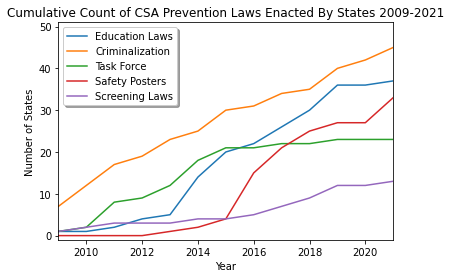

In [65]:
#FIGURE 10 CORRECTION TO Y LABEL

%matplotlib inline
c['Screening Date Enacted'].loc[49] = pd.to_datetime(2021,format='%Y')
c['Screening Date Enacted'].loc[57] = pd.to_datetime(2011, format='%Y')
c['Screening Date Enacted'] = pd.to_datetime(c['Screening Date Enacted'])
c['Effective Date'] = pd.to_datetime(c['Effective Date'])
c['Criminalization Date Enacted'] = pd.to_datetime(c['Criminalization Date Enacted'])

ed = c.groupby(c['Effective Date'].dt.year).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Effective Date']), left_on = 'Effective Date', right_on = 'Effective Date', how = 'outer').fillna(0).sort_values('Effective Date')['STATE'].cumsum().tolist()
cd = c.groupby(c['Criminalization Date Enacted'].dt.year).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Criminalization Date Enacted']), left_on = 'Criminalization Date Enacted', right_on = 'Criminalization Date Enacted', how = 'outer').fillna(0).sort_values('Criminalization Date Enacted')['STATE'].cumsum().tolist()[4:]
sd = c.groupby(c['Screening Date Enacted'].dt.year).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Screening Date Enacted']), left_on = 'Screening Date Enacted', right_on = 'Screening Date Enacted', how = 'outer').fillna(0).sort_values('Screening Date Enacted')['STATE'].cumsum().tolist()[1:]
tf = c.groupby(c['Task Force Year Enacted']).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Task Force Year Enacted']), left_on = 'Task Force Year Enacted', right_on = 'Task Force Year Enacted', how = 'outer').fillna(0).sort_values('Task Force Year Enacted')['STATE'].cumsum().tolist()
sp = c.groupby(c['Poster Year Enacted']).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Poster Year Enacted']), left_on = 'Poster Year Enacted', right_on = 'Poster Year Enacted', how = 'outer').fillna(0).sort_values('Poster Year Enacted')['STATE'].cumsum().tolist()

years = list(range(2009, 2022))
data_preproc = pd.DataFrame({
    'Year': years, 
    'Education Laws': ed,
    'Criminalization': cd,
    'Task Force': tf,
    'Safety Posters': sp,
    'Screening Laws':sd})

ax = sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Year']))


h,l = ax.get_legend_handles_labels()
plt.legend(h,l, loc='upper left',
           fancybox=True, shadow=True)
ax.set_title('Cumulative Count of CSA Prevention Laws Enacted By States 2009-2021')
ax.set_ylabel('Number of States')
ax.set_ylim(-1,51)
ax.set_xlim(2009, 2021)



In [66]:
order = list(c.sort_values('Effective Date').STATE.unique())

viz2 = trenddf.copy()

viz2['Year_Binary'].replace({1:5}, inplace = True)
viz2['Criminalization'].replace({1:2}, inplace = True)
viz2['Screening'].replace({1:3}, inplace = True)
viz2['Task_Force'].replace({1:4}, inplace = True)
viz2['Posters'].replace({1:1}, inplace = True)


viz2 = pd.DataFrame(np.concatenate((viz2[['STATE','yrs','Posters']],np.concatenate((viz2[['STATE','yrs','Task_Force']],np.concatenate((viz2[['STATE','yrs','Screening']], np.concatenate( (viz2[['STATE','yrs','Year_Binary']].values,viz2[['STATE','yrs','Criminalization']].values), axis=0 ) )))))))
viz2[2] = viz2[2].astype(int)

def label_race (row):
    if row[2] == 1 :
        return 'Education Law'
    if row[2] == 2 :
        return 'Criminalization'
    if row[2] == 3:
        return 'Educator Screening'
    if row[2]  == 4:
        return 'Task Force'
    if row[2] == 5:
        return 'Safety Posters'
    return None

viz2[3] = viz2.apply (lambda row: label_race(row), axis=1)
viz2.rename({0:'STATE',1:'YEAR',2:'VALUE',3:'LABEL'}, axis = 1, inplace = True)



# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(order, range(len(order))))

# Generate a rank column that will be used to sort
# the dataframe numerically
viz2['Tm_Rank'] = viz2['STATE'].map(sorterIndex)

# Here is the result asked with the lexicographic sort
# Result may be hard to analyze, so a second sorting is
# proposed next
## NOTE: 
## Newer versions of pandas use 'sort_values' instead of 'sort'
viz2.sort_values(['Tm_Rank','YEAR'],
        ascending = [True, True], inplace = True)
viz2.drop('Tm_Rank', 1, inplace = True)
viz2

STATE  YEAR  VALUE               LABEL
645       Texas  2005      0                None
1410      Texas  2005      0                None
2175      Texas  2005      0                None
2940      Texas  2005      0                None
3705      Texas  2005      0                None
...         ...   ...    ...                 ...
749   Wisconsin  2019      0                None
1514  Wisconsin  2019      0                None
2279  Wisconsin  2019      3  Educator Screening
3044  Wisconsin  2019      0                None
3809  Wisconsin  2019      2     Criminalization

[3825 rows x 4 columns]

In [67]:
from google.colab import files
hd = {'LABEL':True,'YEAR':True,'VALUE':False,'STATE':False}

fig = px.scatter_polar(viz2, r='VALUE', theta='STATE',
                       color='VALUE',animation_frame='YEAR', width = 900, height = 900, color_continuous_scale = ['#6741a1','#ebb045','#094c94','#76af31','#c20078'], 
                       range_color = [0,5.5], range_r = [0,6]) 
                      #  hover_data = hd)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2)),
                  selector=dict(mode='markers'))
fig.update(layout_coloraxis_showscale=False)
fig.update(layout_showlegend=True)

fig.update_layout(
    template="ggplot2",
    polar = dict(
        radialaxis = dict(showticklabels=False, ticks=''),
        angularaxis = dict(showticklabels=True, ticks='')),
        title = 'Enactment of CSA Laws by State: 2005-2019',)

fig.show()

#Uncomment if you want to download an html of the interactive visualization
# fig.write_html("CSA_law_enactment_interactive.html")
# files.download("CSA_law_enactment_interactive.html")


In [68]:
# Uncomment if you want to export the interactive visualization
# fig.write_html("adoption_of_csa_laws.html") 

###Type of csa educational laws

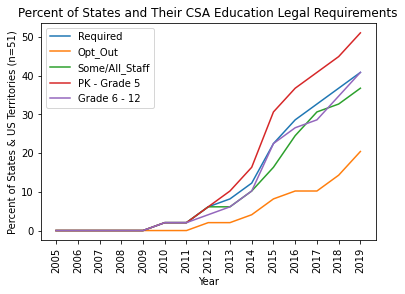

year  Required  Opt_Out  Some_All_Staff  PK_5  G6_12  %_required  \
0   2005         0        0               0     0      0    0.000000   
1   2006         0        0               0     0      0    0.000000   
2   2007         0        0               0     0      0    0.000000   
3   2008         0        0               0     0      0    0.000000   
4   2009         0        0               0     0      0    0.000000   
5   2010         1        0               1     1      1    2.040816   
6   2011         1        0               1     1      1    2.040816   
7   2012         3        1               3     3      2    6.122449   
8   2013         4        1               3     5      3    8.163265   
9   2014         6        2               5     8      5   12.244898   
10  2015        11        4               8    15     11   22.448980   
11  2016        14        5              12    18     13   28.571429   
12  2017        16        5              15    20     14   32.653061   
13  2018        18        7              16    22     17   36.734694   
14  2019        20       10              18    25     20   40.816327   

    %_opt_out  %_Some/All_Staff     %_PK_5     %_6_12  
0    0.000000          0.000000   0.000000   0.000000  
1    0.000000          0.000000   0.000000   0.000000  
2    0.000000          0.000000   0.000000   0.000000  
3    0.000000          0.000000   0.000000   0.000000  
4    0.000000          0.000000   0.000000   0.000000  
5    0.000000          2.040816   2.040816   2.040816  
6    0.000000          2.040816   2.040816   2.040816  
7    2.040816          6.122449   6.122449   4.081633  
8    2.040816          6.122449  10.204082   6.122449  
9    4.081633         10.204082  16.326531  10.204082  
10   8.163265         16.326531  30.612245  22.448980  
11  10.204082         24.489796  36.734694  26.530612  
12  10.204082         30.612245  40.816327  28.571429  
13  14.285714         32.653061  44.897959  34.693878  
14  20.408163         36.734694  51.020408  40.816327

In [69]:
#nature of education laws in terms of required, etc

# Make copy of main df
require_vis_df = df[['STATE', 'year', 'Required', 'Opt_Out', 'Some_All_Staff', 'PK_5',	'G6_12']].copy()

# Set variable to the number of states & territories in df
num_states = len(require_vis_df.STATE.unique())

# Drop state, change df to int, and groupby year
require_vis_df.drop(columns=['STATE'], inplace=True)
require_vis_df = require_vis_df.astype('int32')
require_vis_df = require_vis_df.groupby(['year']).sum().reset_index()

# Calculate the percentage for each of the variables
require_vis_df['%_required'] = (require_vis_df['Required'] / num_states) * 100
require_vis_df['%_opt_out'] = (require_vis_df['Opt_Out'] / num_states) * 100
require_vis_df['%_Some/All_Staff'] = (require_vis_df['Some_All_Staff'] / num_states) * 100
require_vis_df['%_PK_5'] = (require_vis_df['PK_5'] / num_states) * 100
require_vis_df['%_6_12'] = (require_vis_df['G6_12'] / num_states) * 100

# Plot each line
plt.plot(require_vis_df['year'], require_vis_df['%_required'], label = "Required")
plt.plot(require_vis_df['year'], require_vis_df['%_opt_out'], label = "Opt_Out")
plt.plot(require_vis_df['year'], require_vis_df['%_Some/All_Staff'], label = "Some/All_Staff")
plt.plot(require_vis_df['year'], require_vis_df['%_PK_5'], label = "PK - Grade 5")
plt.plot(require_vis_df['year'], require_vis_df['%_6_12'], label = "Grade 6 - 12")

# Fix x-axis lables, set title and axis labels
xlabels = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.title("Percent of States and Their CSA Education Legal Requirements")
plt.xlabel('Year')
plt.ylabel('Percent of States & US Territories (n=51)')
plt.xticks(require_vis_df['year'], xlabels, rotation='vertical')

# Uncomment below 2 lines if you would prefer the y-axis go to 100%
# x1,x2,y1,y2 = plt.axis()  
# plt.axis((x1,x2,0,100))

# Add legend and show the plot
plt.legend()
plt.show()

# Also show the df so reader can see specific percentages
require_vis_df.head(15)

## Y-Value/CSA Visualizations


### y = sub_csa_cases

In [70]:
# Substantiated Cases overtime in all states

# Create subset of main df and format
sub_vis_df = df[['STATE', 'year', 'sub_csa_cases']].copy()
sub_vis_df['year'] = sub_vis_df['year'].apply(str)
avg_line3 = sub_vis_df.groupby('year').mean().reset_index()
avg_line3['Legend'] = 'Average'

color_range = ['lightgray']

# Create the main plot lines
sub_vis_plot = alt.Chart(sub_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_csa_cases', title='# Substantiated CSA Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add blue line for average
y_line = alt.Chart(avg_line3).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_csa_cases'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine main plot with average line
final_sub_vis = sub_vis_plot + y_line

# Set title
final_sub_vis.properties(
    title = {
      "text": ["Substantiated Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )


alt.LayerChart(...)

In [71]:
# Visual of the first 6 states to enact the law
# black line is the year enacted

# Pull out only the first 6 states to enact the law
top_6_states = ['Texas', 'Vermont', 'Michigan', 'Indiana', 'Illinois', 'Mississippi']
top_6_df = df[['STATE', 'year', 'Effective_Date', 'sub_csa_cases']].copy()

# Create a smaller subset of main df and format
top_6_df = top_6_df[top_6_df['STATE'].isin(top_6_states)]
top_6_df['Year'] = pd.to_datetime(top_6_df['Effective_Date']).dt.year
top_6_df['year'] = top_6_df['year'].apply(str)

# Create a function that will create a line chart for a given state
def create_chart(state):
  df = top_6_df[top_6_df['STATE'] == state]
  enact_year = df['Year'].iloc[0]
  df['ey'] = enact_year
  df['ey'] = df['ey'].apply(str)
  df['Legend'] = 'Year Law is Effective'

  df_chart = alt.Chart(df[['year','sub_csa_cases']]).mark_line().encode(
      x=alt.X('year', title='Year'),
      y=alt.Y('sub_csa_cases', title='# Substantiated CSA Cases'),
  )

  df_rule = alt.Chart(df[['ey','Legend']]).mark_rule().encode(
      x='ey',
      size=alt.value(2),
      opacity=alt.Opacity('Legend', legend=alt.Legend(title="Legend"))
  )

  final_vis = df_chart + df_rule
  final_vis = final_vis.properties(title=f'{state}', height=200, width=250)

  return final_vis

# Create a plot for each of the top 6 states
texas_vis = create_chart('Texas')
vermont_vis = create_chart('Vermont')
michigan_vis = create_chart('Michigan')

indiana_vis = create_chart('Indiana')
illinois_vis = create_chart('Illinois')
miss_vis = create_chart('Mississippi')

# hconcat the state visuals into rows
row1 = texas_vis | vermont_vis | michigan_vis
row2 = indiana_vis | illinois_vis | miss_vis

# vconcat the rows to create a small multiples plot
final = (row1 & row2).properties(
    title='Number of CSA Cases Over Time in the First 6 States to Enforce a Law'
    ).configure_title(anchor='middle', fontSize=15,)

# Show the visual    
final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

alt.VConcatChart(...)

###y = rep_csa_cases

In [72]:
# Create a visual of the reported csa cases over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'rep_csa_cases']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
avg_line_rcc = y_vis_df.groupby('year').mean().reset_index()
avg_line_rcc['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('rep_csa_cases', title='Reported CSA cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_rcc).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('rep_csa_cases'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Reported CSA Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

alt.LayerChart(...)

### y = sub_ca_cases

In [73]:
# Create a visual of all cases over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'sub_ca_cases']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
avg_line_ac = y_vis_df.groupby('year').mean().reset_index()
avg_line_ac['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_ca_cases', title='All Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_ac).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_ca_cases'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["All Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

alt.LayerChart(...)

###y = sub_rep_csa_ratio

In [74]:
# Create a visual of ratio of reported to substantiated cases over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'sub_rep_csa_ratio']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
avg_line = y_vis_df.groupby('year').mean().reset_index()
avg_line['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_rep_csa_ratio', title='Ratio of Reported to Substantiated Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_rep_csa_ratio'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Ratio of Reported to Substantiated Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

alt.LayerChart(...)

In [75]:
# Same visual as above but with only states that have a year_enacted date

# Create smaller subset of main df and format it appropriately 
y_vis2_df = df[['STATE', 'Effective_Date', 'year', 'sub_rep_csa_ratio']].copy() #changed year enacted to effective date
y_vis2_df.dropna(subset=['Effective_Date'], inplace=True)
y_vis2_df['year'] = y_vis2_df['year'].apply(str)
y_vis2_df['Year'] = pd.to_datetime(y_vis2_df['Effective_Date']).dt.year

# Drop any states with year enacted as 2019 or 2020 - to short to see difference
y_vis2_df = y_vis2_df[~y_vis2_df['Year'].isin([2019, 2020])]

# Create the average line
avg_line2 = y_vis2_df.groupby('year').mean().reset_index()
avg_line2['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the main lines
y_plot = alt.Chart(y_vis2_df[['year','sub_rep_csa_ratio','STATE']]).mark_line().encode(
    x=alt.X('year',title='Year'),
    y=alt.Y('sub_rep_csa_ratio', title='Ratio of Reported to Substantiated Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it\
)

# Plot the average line
y_line = alt.Chart(avg_line2).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_rep_csa_ratio'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the plot with the average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Ratio of Reported to Substantiated Cases Over Time"], 
      "subtitle": ["Only States With a CSA Law"]}
    )


alt.LayerChart(...)

###y = sub_csa_yc

In [76]:
# Create a visual of csa cases Yearly change metric over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'sub_csa_yc']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
y_vis_df.dropna(inplace=True) #### DROP LINE WHEN NANS FIXED
y_vis_df['sub_csa_yc'] = y_vis_df['sub_csa_yc'].apply(float)

avg_line_car = y_vis_df.groupby('year').mean().reset_index()
avg_line_car['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_csa_yc', title='CSA Cases Yearly Change Metric'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_car).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_csa_yc'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["CSA Cases Yearly Change Metric Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

alt.LayerChart(...)

###y = sub_ca_yc

In [77]:
# Create a visual of substantiated CSA cases yearly change metric over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'sub_ca_yc']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
y_vis_df['sub_ca_yc'] = y_vis_df['sub_ca_yc'].apply(float)

avg_line_car = y_vis_df.groupby('year').mean().reset_index()
avg_line_car['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_ca_yc', title='Substantiated CA Cases Yearly Change Metric'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_car).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_ca_yc'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Substantiated CA Cases Yearly Change Metric Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

alt.LayerChart(...)

###y = rep_csa_inc

In [78]:
# Create a visual of incompletely reviewed CSA cases over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'rep_csa_inc']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
y_vis_df['rep_csa_inc'] = y_vis_df['rep_csa_inc'].apply(float)

avg_line_car = y_vis_df.groupby('year').mean().reset_index()
avg_line_car['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('rep_csa_inc', title='Number of Incompletely Reviewed CSA Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_car).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('rep_csa_inc'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Number of Incompletely Reviewed CSA Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

alt.LayerChart(...)

## Demographic Visualizations

### Population Visualization

In [79]:
from bokeh.layouts import column
from bokeh.plotting import figure, output_file, save


In [80]:
# Command called that allows you to open your Bokeh visuals inside of the notebook
output_notebook()

In [81]:
# Import shapefile for usa map
usa_map = gpd.read_file('cb_2018_us_state_20m.shp')
usa_map.rename(columns={'NAME':'State'}, inplace=True)

# Import population dataset, fix columnn names, and set index to state
pop = pd.read_excel('Population_state_lvl.xlsx',)
pop.rename(columns={'Area':'State'}, inplace=True)
pop = pop.set_index('State')

# Make a copy of the dataset (NOT averaged) for visualization
pop_not_avg = pop.copy()

In [82]:
# Clean data nd create visual for population by year
values_by_state = usa_map.merge(pop_not_avg, on=['State'], how='right')

output_file(filename="pop_by_year.html")

# Need to move Alaska and Hawaii so they're not off to the side
def fix_map(row):
    if row['State'] == 'Alaska':
        geom = affinity.translate(shape(row['geometry']), xoff=-62, yoff=-35)
        geom = affinity.scale(geom, .4, .55)

        return geom
    elif row['State'] == 'Hawaii':
        geom = affinity.translate(shape(row['geometry']), xoff=48, yoff=5)
        return geom

    return row['geometry']

fixed_population_by_state = values_by_state.copy()
fixed_population_by_state['geometry'] = values_by_state.apply(fix_map, axis=1)
# Make a copy of the first year for later use in the visual
fixed_population_by_state['selectedYear'] = fixed_population_by_state[2005]

# Set up the visual
part_map = figure(title = "Population By State Over Time",
            plot_height = 400,
            plot_width = 800,
            tools = 'pan, wheel_zoom, reset',
            toolbar_location = 'below',
            x_range = (-138, -64))
part_map.xgrid.grid_line_color = None
part_map.ygrid.grid_line_color = None
part_map.axis.visible = False
part_map.outline_line_color = None

# Choose color pallete
palette = tuple(reversed(palette))
color_mapper = LogColorMapper(palette=palette, low = 500000, high = 36000000)

# Set custom tick list and ticker for the color bar
tick_list = [500000, 17750000, 36000000]
ticker = FixedTicker(ticks=[600000, 1200000, 2300000, 4100000, 7600000, 14500000, 27000000])

# Set up the color bar
color_bar = ColorBar(color_mapper = color_mapper,
                     ticker = ticker,
                     label_standoff = 15,
                     border_line_color = None,
                     location = (0,0),
                     width = 20,
                     height = 200)

# Convert dataframe to json
newgeo = GeoJSONDataSource(geojson = fixed_population_by_state.to_json())

states = part_map.patches(
    'xs',
    'ys',
    source = newgeo,
    fill_color = {'field':'selectedYear', 'transform': color_mapper},
    line_color = 'black',
    line_width = 0.25,
    fill_alpha = 1,
)

# Add the color bar
part_map.add_layout(color_bar, 'right')

# Add the hovertool
part_map.add_tools(HoverTool(renderers = [states], tooltips = [('State', '@State'), ('Population', '@{selectedYear}{int}')]))

# Add the slider
slider = Slider(title = 'Year', 
                start = 2005,
                end = 2019,
                step = 1,
                value = 2005)

slider.js_on_change("value", CustomJS(
    args={
        "dataSource": newgeo,
    },
    code="""
        const year = cb_obj.value;
        const newData = dataSource.data[`${year}`];
        
        dataSource.data.selectedYear = newData;
        dataSource.change.emit();
    """,
))

population_layout = column(
    part_map,
    slider
)

# Let's see how it works!
show(population_layout)

# Uncomment next line if you want to export the visual
# save(population_layout)  


### Median Household Visualization

In [83]:
# Import MHI data, fix column names, drop empty rows
mhi = pd.read_excel('mhi_state_lvl.xlsx', header=1)
mhi.rename(columns={'Unnamed: 0':'State'}, inplace=True)
mhi.drop(mhi.tail(3).index, inplace=True)
mhi = mhi[1:]
mhi_unstacked = mhi.copy()
mhi_unstacked.set_index('State', inplace=True)
mhi_unstacked = mhi_unstacked.astype('int32')

In [84]:
# Clean data and create visual for mhi by year
values_by_state2 = usa_map.merge(mhi_unstacked, on=['State'], how='right')

output_file(filename="mhi_by_year.html")

fixed_mhi_by_state = values_by_state2.copy()
fixed_mhi_by_state['geometry'] = values_by_state2.apply(fix_map, axis=1)
# Make a copy of the first year for later use in the visual
fixed_mhi_by_state['selectedYear'] = fixed_mhi_by_state[2005]

# Set up the visual
part_map = figure(title = "Median Household Income By State Over Time",
            plot_height = 400,
            plot_width = 800,
            tools = 'pan, wheel_zoom, reset',
            toolbar_location = 'below',
            x_range = (-138, -64))
part_map.xgrid.grid_line_color = None
part_map.ygrid.grid_line_color = None
part_map.axis.visible = False
part_map.outline_line_color = None

# Choose color pallete
palette = tuple(reversed(palette))
color_mapper = LogColorMapper(palette=palette, low = 32000, high = 91000)

# Set custom tick list and ticker for the color bar
tick_list = [32000, 42000, 91000]
ticker = FixedTicker(ticks=[35000, 40000, 46000, 53000, 63000, 72000, 85000])

# Set up the color bar
color_bar = ColorBar(color_mapper = color_mapper,
                     ticker = ticker,
                     label_standoff = 15,
                     border_line_color = None,
                     location = (0,0),
                     width = 20,
                     height = 200)

# Convert dataframe to json
newgeo = GeoJSONDataSource(geojson = fixed_mhi_by_state.to_json())

states = part_map.patches(
    'xs',
    'ys',
    source = newgeo,
    fill_color = {'field':'selectedYear', 'transform': color_mapper},
    line_color = 'black',
    line_width = 0.25,
    fill_alpha = 1,
)

# Add the color bar
part_map.add_layout(color_bar, 'right')

# Add the hovertool
part_map.add_tools(HoverTool(renderers = [states], tooltips = [('State', '@State'), ('Median Household Income', '@{selectedYear}{int}')]))

# Add the slider
slider = Slider (title = 'Year', 
                start = 2005,
                end = 2019,
                step = 1,
                value = 2005)

slider.js_on_change("value", CustomJS(
    args={
        "dataSource": newgeo,
    },
    code="""
        const year = cb_obj.value;
        const newData = dataSource.data[`${year}`];
        
        dataSource.data.selectedYear = newData;
        dataSource.change.emit();
    """,
))

mhi_layout = column(
    part_map,
    slider
)

# Let's see how it works!
show(mhi_layout)

# uncomment next line if you want to export the visual
save(mhi_layout)

'/content/mhi_by_year.html'

### Unemployment Visualization

In [85]:
# Import unemployment data, rename columns, and drop first row (US Summary)
unemploy = pd.read_excel('Unemployment_rate_state_lvl.xlsx',)
unemploy.rename(columns={'Area':'State'}, inplace=True)
unemploy = unemploy[1:]
unemploy_unstacked = unemploy.copy()
unemploy_unstacked.drop(unemploy_unstacked.tail(4).index, inplace=True)
unemploy_unstacked.set_index('State', inplace=True)

In [86]:
# Clean data and create visual for unemployment rate by year
values_by_state3 = usa_map.merge(unemploy_unstacked, on=['State'], how='right')

output_file(filename="ur_by_year.html")

fixed_unemploy_by_state = values_by_state3.copy()
fixed_unemploy_by_state['geometry'] = values_by_state3.apply(fix_map, axis=1)
# Make a copy of the first year for later use in the visual
fixed_unemploy_by_state['selectedYear'] = fixed_unemploy_by_state[2005]

# Set up the visual
part_map = figure(title = "Unemployment Rate (%) By State Over Time",
            plot_height = 400,
            plot_width = 800,
            tools = 'pan, wheel_zoom, reset',
            toolbar_location = 'below',
            x_range = (-138, -64))
part_map.xgrid.grid_line_color = None
part_map.ygrid.grid_line_color = None
part_map.axis.visible = False
part_map.outline_line_color = None

# Choose color pallete
palette = tuple(reversed(palette))
color_mapper = LogColorMapper(palette=palette, low = 2.2, high = 14)

# Set custom tick list and ticker for the color bar
tick_list = [2, 4, 6]
ticker = FixedTicker(ticks=[2.5, 3.3, 4.1, 5.5, 7.4, 9.8, 12.5])

# Set up the color bar
color_bar = ColorBar(color_mapper = color_mapper,
                     ticker = ticker,
                     label_standoff = 15,
                     border_line_color = None,
                     location = (0,0),
                     width = 20,
                     height = 200)

# Convert dataframe to json
newgeo = GeoJSONDataSource(geojson = fixed_unemploy_by_state.to_json())

states = part_map.patches(
    'xs',
    'ys',
    source = newgeo,
    fill_color = {'field':'selectedYear', 'transform': color_mapper},
    line_color = 'black',
    line_width = 0.25,
    fill_alpha = 1,
)

# Add the color bar
part_map.add_layout(color_bar, 'right')

# Add the hovertool
part_map.add_tools(HoverTool(renderers = [states], tooltips = [('State', '@State'), ('Unemployment Rate (%)', '@{selectedYear}{int}')]))

# Add the slider
slider = Slider (title = 'Year', 
                start = 2005,
                end = 2019,
                step = 1,
                value = 2005)

slider.js_on_change("value", CustomJS(
    args={
        "dataSource": newgeo,
    },
    code="""
        const year = cb_obj.value;
        const newData = dataSource.data[`${year}`];
        
        dataSource.data.selectedYear = newData;
        dataSource.change.emit();
    """,
))

unemploy_layout = column(
    part_map,
    slider
)

# Let's see how it works!
show(unemploy_layout)

# uncomment next line if you want to export the visual
# save(unemploy_layout)

#Evaluating reverse causation

In [87]:
newly_adopted_states = df[df['post'] == 1].drop('index', axis = 1).reset_index().sort_values('year').groupby(['STATE']).first().reset_index().groupby('year').sum().apply(lambda x: (x['sub_csa_cases']/x['pop']) * 100000, axis = 1).reset_index()

In [88]:
non_new_count = df[df['STATE'].isin(df[(df['post'] == 0) & (df['year'] == 2019)]['STATE'].unique())].groupby('year').sum().apply(lambda x: (x['sub_csa_cases']/x['pop']) * 100000, axis = 1).reset_index()

In [89]:
newly_adopted_states

year           0
0  2010   33.278239
1  2012   89.440177
2  2013   56.032103
3  2014  121.393765
4  2015   40.046200
5  2016  125.819040
6  2017   45.449040
7  2018   47.583345
8  2019  129.483158

In [90]:
non_new_count

year          0
0   2005  65.258000
1   2006  59.963382
2   2007  64.783009
3   2008  64.365036
4   2009  70.919002
5   2010  65.453916
6   2011  80.145515
7   2012  66.616919
8   2013  62.084870
9   2014  77.447017
10  2015  68.524646
11  2016  74.530179
12  2017  76.196359
13  2018  70.972244
14  2019  77.523188

In [91]:
viz11 = pd.concat([non_new_count, newly_adopted_states])

In [92]:
viz11['num'] = 0
viz11['num'][15:] = 1
viz11.rename({0:'cases_per_100k'}, inplace = True, axis = 1)
viz11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



year  cases_per_100k  num
0   2005       65.258000    0
1   2006       59.963382    0
2   2007       64.783009    0
3   2008       64.365036    0
4   2009       70.919002    0
5   2010       65.453916    0
6   2011       80.145515    0
7   2012       66.616919    0
8   2013       62.084870    0
9   2014       77.447017    0
10  2015       68.524646    0
11  2016       74.530179    0
12  2017       76.196359    0
13  2018       70.972244    0
14  2019       77.523188    0
0   2010       33.278239    1
1   2012       89.440177    1
2   2013       56.032103    1
3   2014      121.393765    1
4   2015       40.046200    1
5   2016      125.819040    1
6   2017       45.449040    1
7   2018       47.583345    1
8   2019      129.483158    1

Text(0.5, 0, 'Year')

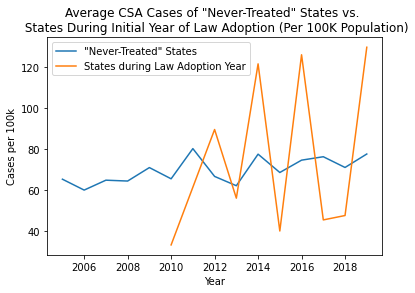

In [93]:
#Blue line is the average of the never treated states from 2005-2019 
#orange line is the average of states in their first year of having a 1 in post or the first year the law was effective. 

%matplotlib inline
plt.plot(viz11[viz11['num'] == 0]['year'],viz11[viz11['num'] == 0]['cases_per_100k'], label = '"Never-Treated" States') #blue line
plt.plot(viz11[viz11['num'] == 1]['year'],viz11[viz11['num'] == 1]['cases_per_100k'], label = 'States during Law Adoption Year') #orange line
plt.legend()
plt.title('Average CSA Cases of "Never-Treated" States vs. \n States During Initial Year of Law Adoption (Per 100K Population)')
plt.ylabel('Cases per 100k')
plt.xlabel('Year')

#Parallel trends assumption anaysis

##Parallel trends visulaizations

In [94]:
# Create a parallel trends assumption visualization

# Create smaller subset of main df and format
parallel_df = df[['STATE', 'Effective_Date', 'year', 'sub_csa_cases']].copy()
parallel_df = parallel_df.rename(columns={"year": "yrs"})
parallel_df['year'] = pd.to_datetime(parallel_df['Effective_Date']).dt.year
parallel_df['year'] = parallel_df['year'].replace({2019: np.nan})
parallel_df['year'] = parallel_df['year'].replace({2020: np.nan})

# # Create control subset of main df and format
control_df = parallel_df[parallel_df['year'].isnull()]
control_df['offset_year'] = control_df['yrs'] - 2009
control_df['label'] = 'Control'
# # Reduce dataset to just 4 years before and after treatment
values = [-4, -3, -2, -1, 0 , 1, 2, 3, 4]
control_df = control_df[control_df['offset_year'].isin(values)]

# Create treatment subset of main df and format
treatment_df = parallel_df[~parallel_df['year'].isnull()]
treatment_df['offset_year'] = treatment_df['yrs'] - treatment_df['year']
treatment_df['label'] = 'Treatment'
# Reduce dataset to just 4 years before and after treatment
treatment_df = treatment_df[treatment_df['offset_year'].isin(values)]

# append the 2 dataframes together for ease of visualization
final_parallel_df = treatment_df.append(control_df, ignore_index=True)
final_parallel_df['treatment_year'] = 0

final_treat_df = treatment_df.copy()
final_treat_df.rename(columns={"sub_csa_cases": "Treatment CSA Cases"}, inplace=True)
final_control_df = control_df.copy()
final_control_df.rename(columns={"sub_csa_cases": "Control CSA Cases"}, inplace=True)
final_df = final_treat_df.append(final_control_df, ignore_index=True)
final_df = final_df.fillna(0)
final_df.drop(columns=['Effective_Date', 'yrs', 'year', 'label'], inplace=True)

combine_plot = alt.Chart(final_df).mark_line().transform_fold(
    fold=['Treatment CSA Cases', 'Control CSA Cases'],
    as_=['variable', 'value']
).encode(
    x=alt.X('offset_year', title='Year Since Treatment'),
    y=alt.Y('max(value):Q', title='# Substantiated CSA Cases'),
    color=alt.Color('variable:N', legend=alt.Legend(title='Legend')),
    opacity=alt.Opacity('STATE:N', legend=None)
)

# Add vertical line to emphasize year 0
df_rule = alt.Chart(final_parallel_df[['treatment_year']]).mark_rule().encode(
    x='treatment_year',
    size=alt.value(2)
)

# Combine all the parts
final_sub_vis = (combine_plot + df_rule)

# Set the title
final_sub_vis.properties(
    title = {
      "text": ["Parallel Trends Assumption"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

alt.LayerChart(...)

Weight the # CSA substantiated cases with demograpghic data

In [95]:
# Create a smaller subset of main df
parallel_df = df[['STATE', 'Effective_Date', 'year', 'sub_csa_cases', 
                  'median_household_income', 'pop', 'Unemployment_rate']].copy()

# Weight 'sub_csa_cases' on the demographic info
parallel_df['csa_weighted'] = parallel_df['sub_csa_cases'] * (1/parallel_df['pop']) * (1/parallel_df['median_household_income']) * parallel_df['Unemployment_rate']

parallel_df = parallel_df.rename(columns={"year": "yrs"})
parallel_df['year'] = pd.to_datetime(parallel_df['Effective_Date']).dt.year
parallel_df['year'] = parallel_df['year'].replace({2019: np.nan})
parallel_df['year'] = parallel_df['year'].replace({2020: np.nan})

# # Create control subset of main df and format
control_df = parallel_df[parallel_df['year'].isnull()]
control_df['offset_year'] = control_df['yrs'] - 2009
control_df['label'] = 'Control'
# # Reduce dataset to just 4 years before and after treatment
values = [-4, -3, -2, -1, 0 , 1, 2, 3, 4]
control_df = control_df[control_df['offset_year'].isin(values)]

# Create treatment subset of main df and format
treatment_df = parallel_df[~parallel_df['year'].isnull()]
treatment_df['offset_year'] = treatment_df['yrs'] - treatment_df['year']
treatment_df['label'] = 'Treatment'
# Reduce dataset to just 4 years before and after treatment
treatment_df = treatment_df[treatment_df['offset_year'].isin(values)]

# append the 2 dataframes together for ease of visualization
final_parallel_df = treatment_df.append(control_df, ignore_index=True)
final_parallel_df['treatment_year'] = 0

final_treat_df = treatment_df.copy()
final_treat_df.rename(columns={"csa_weighted": "Treatment CSA Cases"}, inplace=True)
final_control_df = control_df.copy()
final_control_df.rename(columns={"csa_weighted": "Control CSA Cases"}, inplace=True)
final_df = final_treat_df.append(final_control_df, ignore_index=True)
final_df = final_df.fillna(0)
final_df.drop(columns=['Effective_Date', 'yrs', 'year', 'label'], inplace=True)

combine_plot = alt.Chart(final_df).mark_line().transform_fold(
    fold=['Treatment CSA Cases', 'Control CSA Cases'],
    as_=['variable', 'value']
).encode(
    x=alt.X('offset_year', title='Year Since Treatment'),
    y=alt.Y('max(value):Q', title='Weighted # Substantiated CSA Cases'),
    color=alt.Color('variable:N', legend=alt.Legend(title='Legend')),
    opacity=alt.Opacity('STATE:N', legend=None)
)

# Add vertical line to emphasize year 0
df_rule = alt.Chart(final_parallel_df[['treatment_year']]).mark_rule().encode(
    x='treatment_year',
    size=alt.value(2)
)

# Combine all the parts
final_sub_vis = (combine_plot + df_rule)

# Set the title
final_sub_vis.properties(
    title = {
      "text": ["Parallel Trends Assumption Weighted on Demographic Info"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

alt.LayerChart(...)

##Parallel trends state by state analysis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

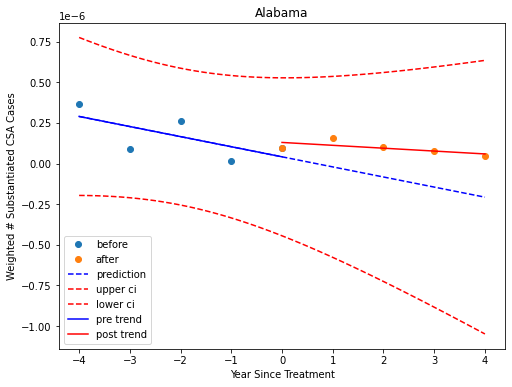

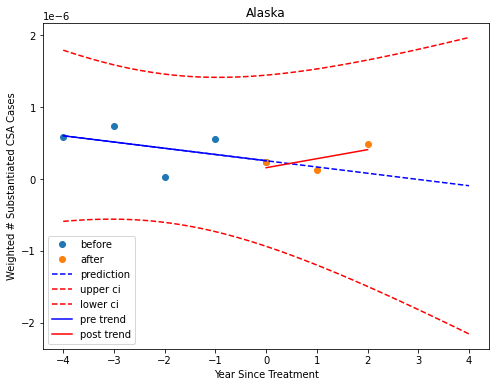

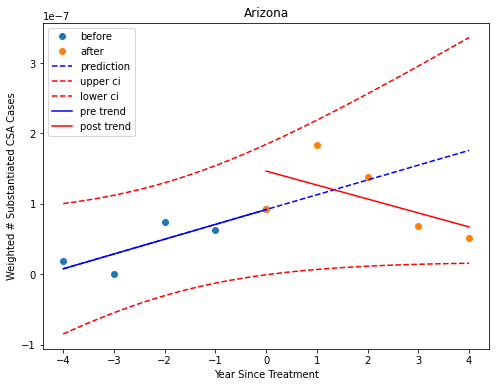

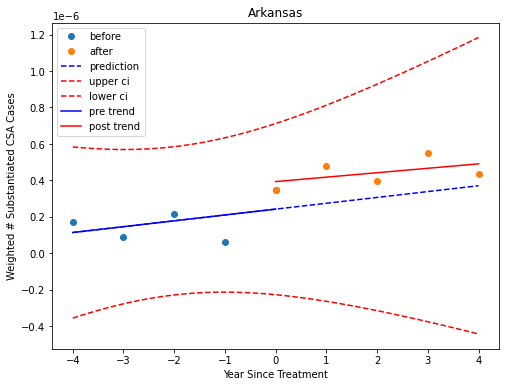

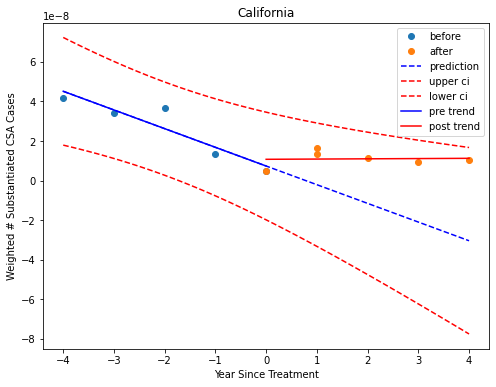

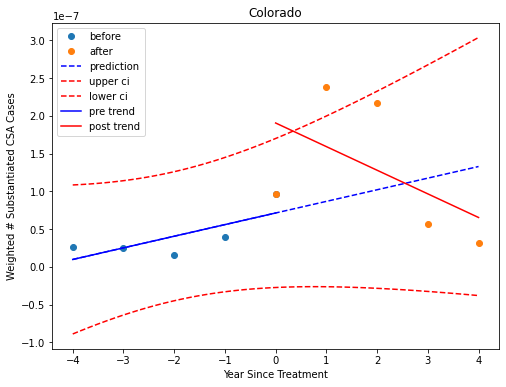

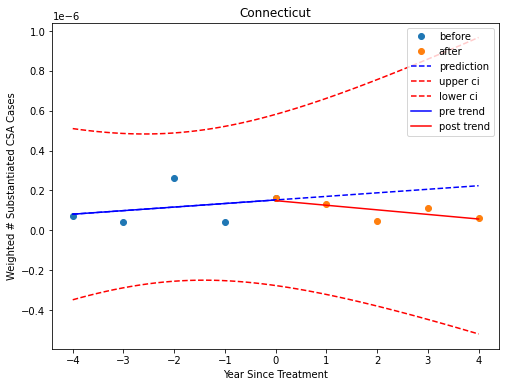

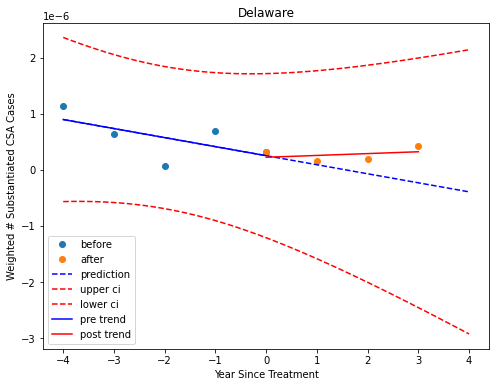

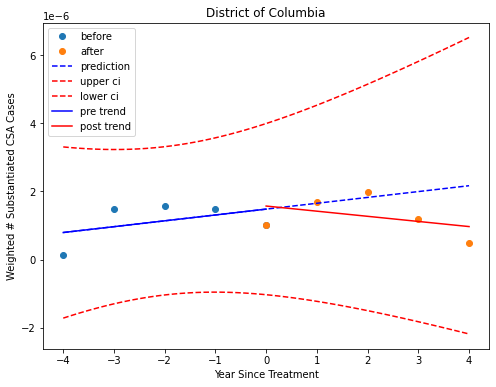

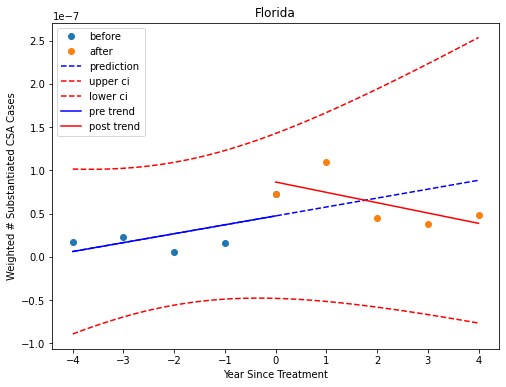

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning:

divide by zero encountered in double_scalars



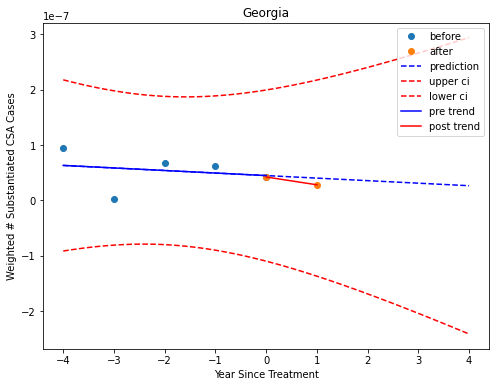

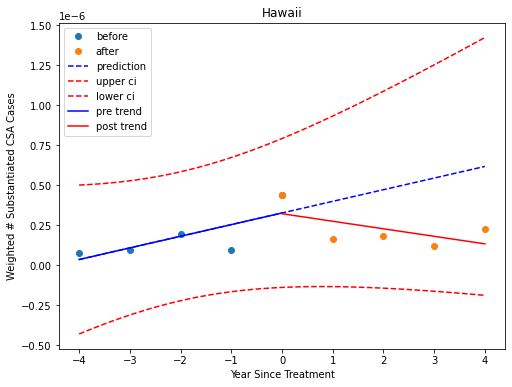

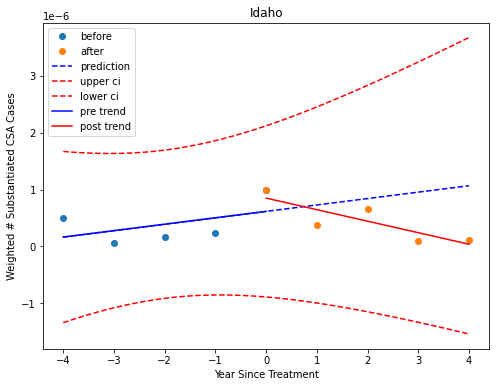

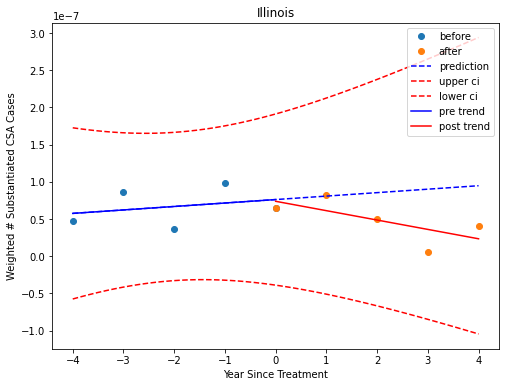

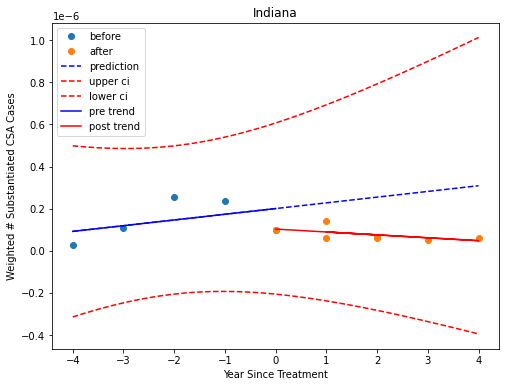

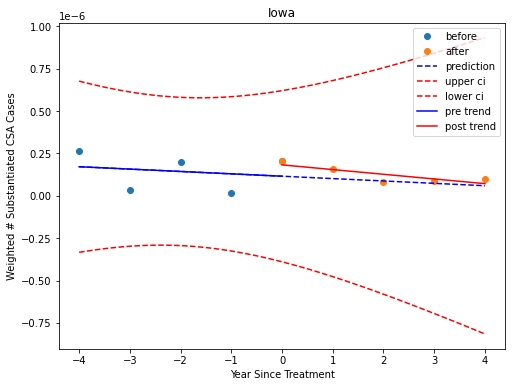

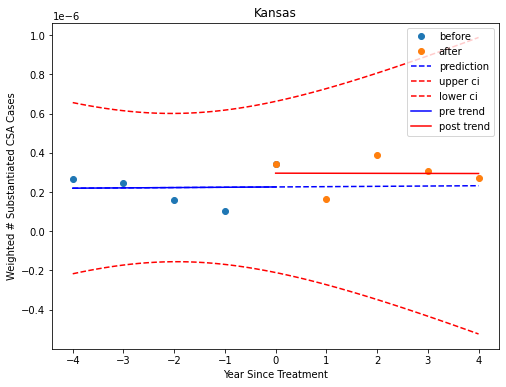

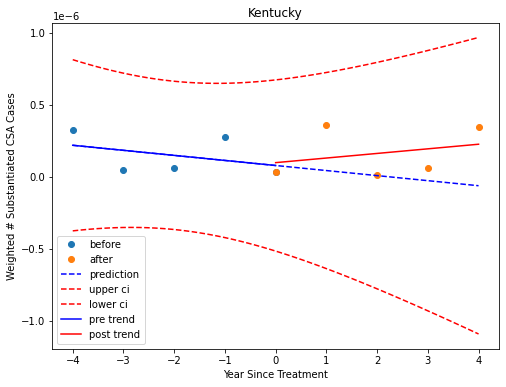

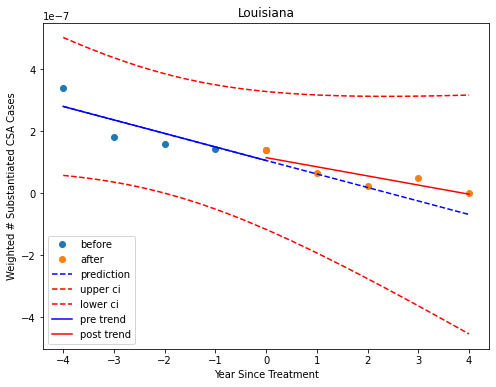

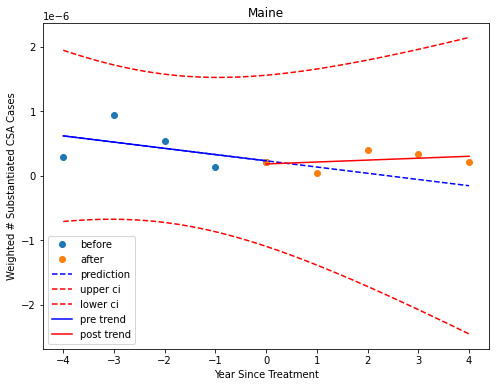

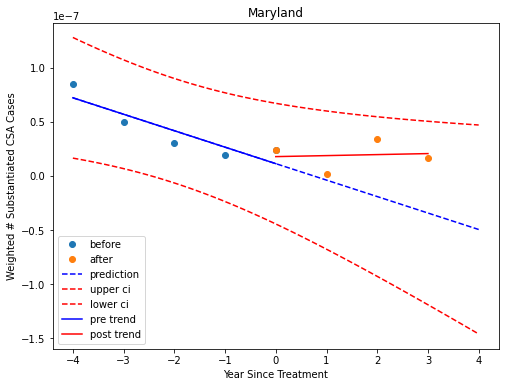

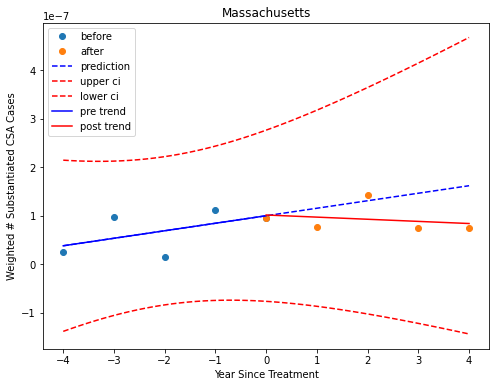

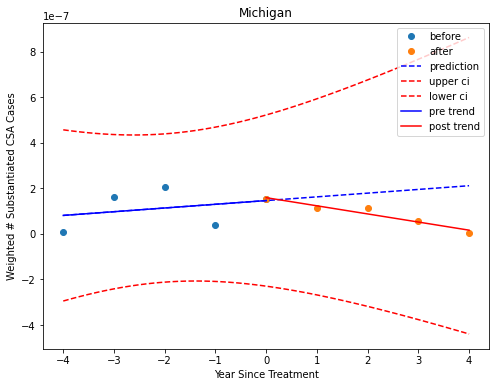

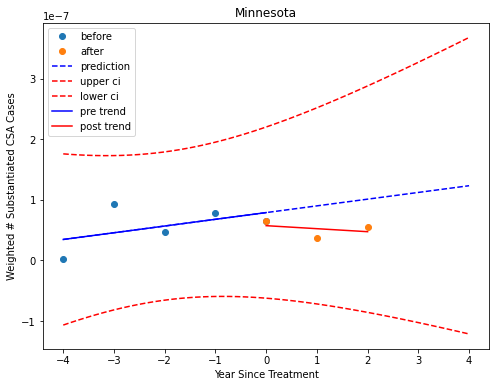

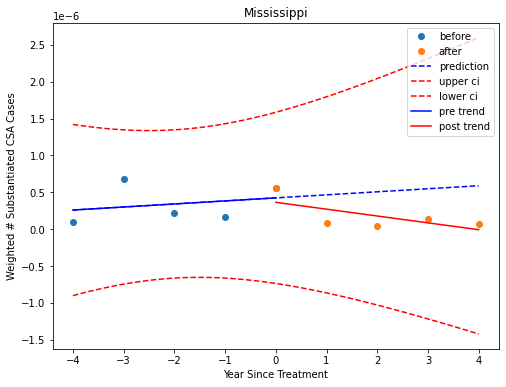

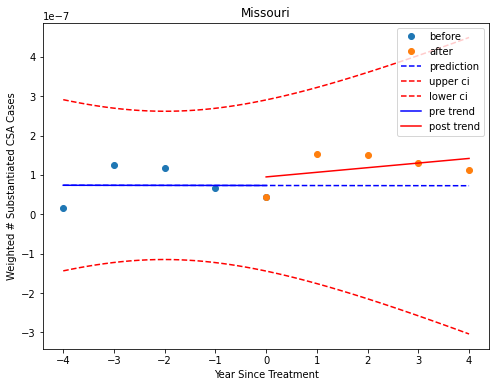

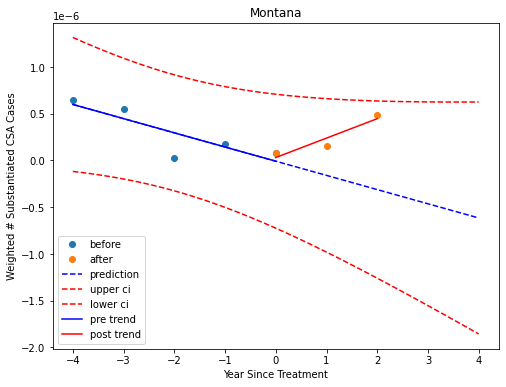

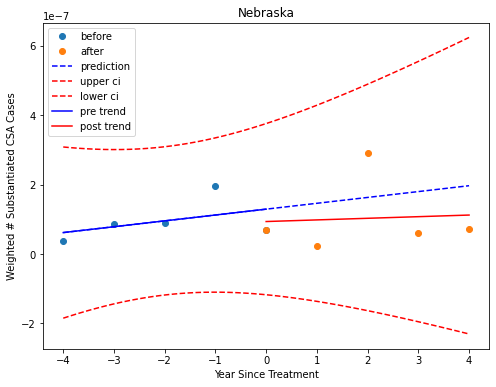

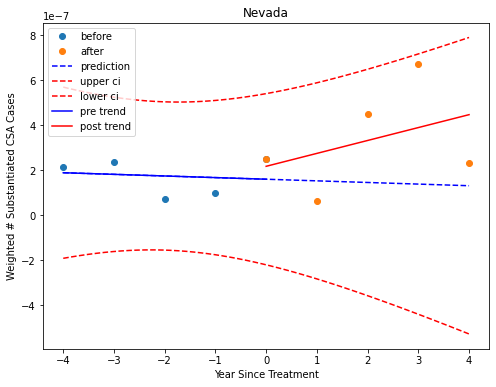

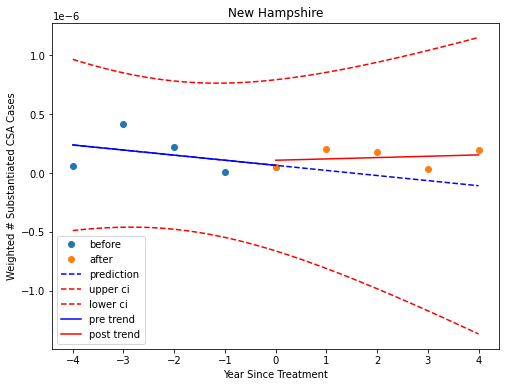

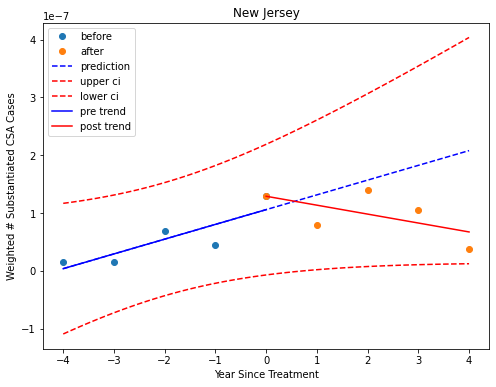

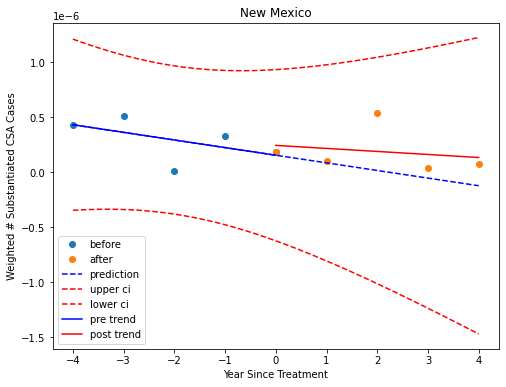

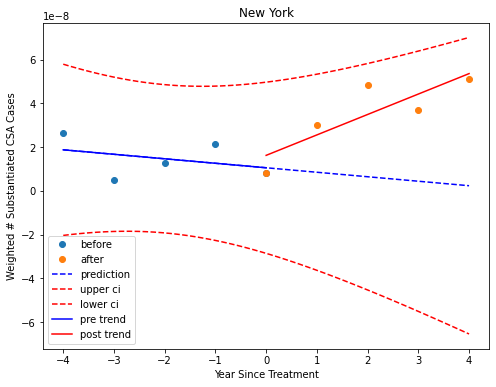

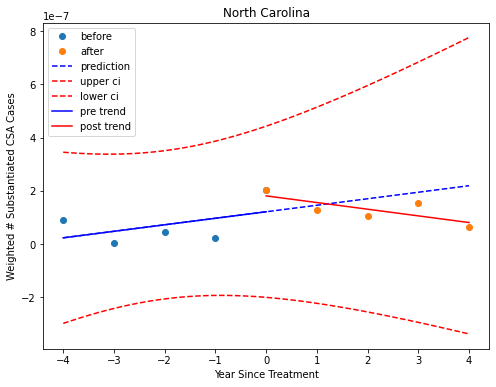

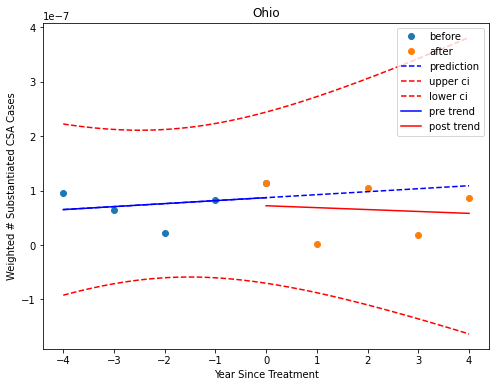

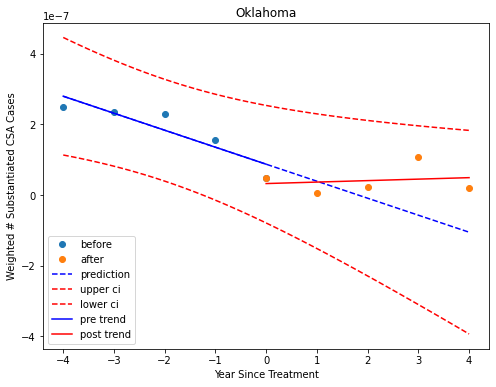

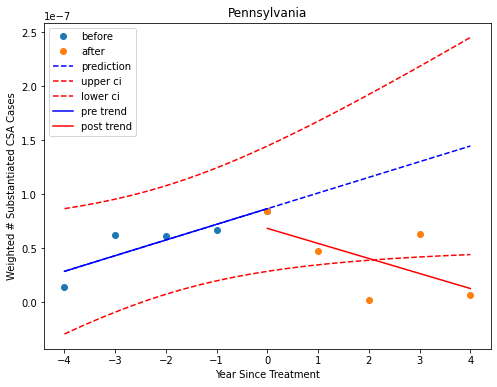

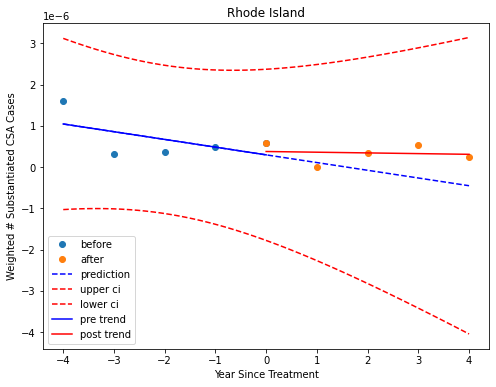

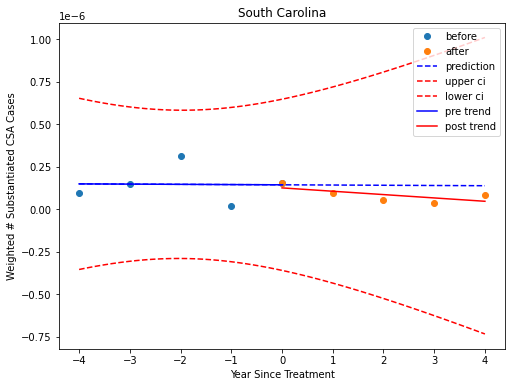

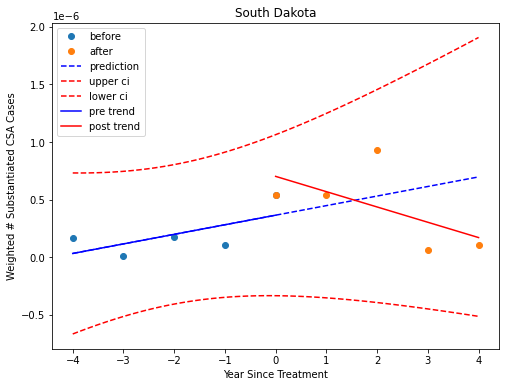

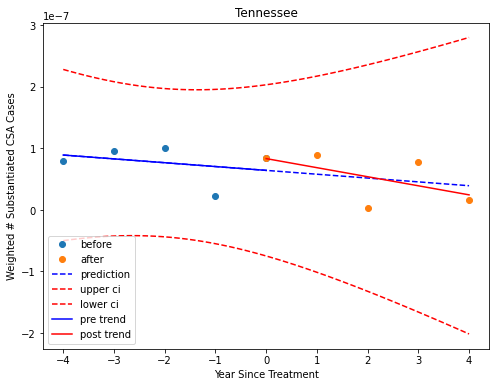

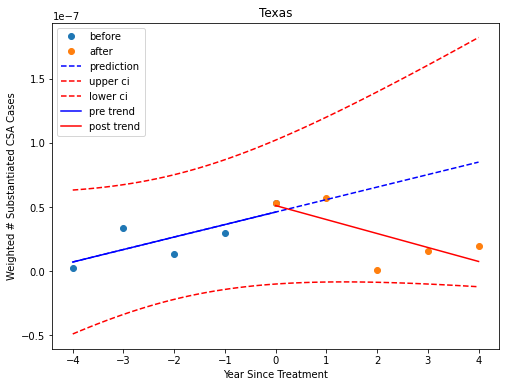

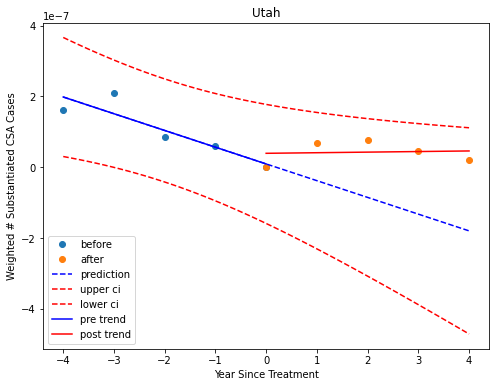

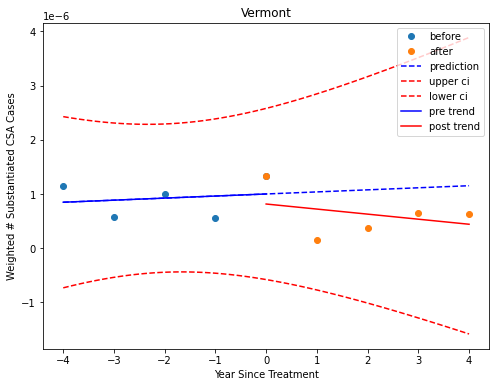

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning:

divide by zero encountered in double_scalars



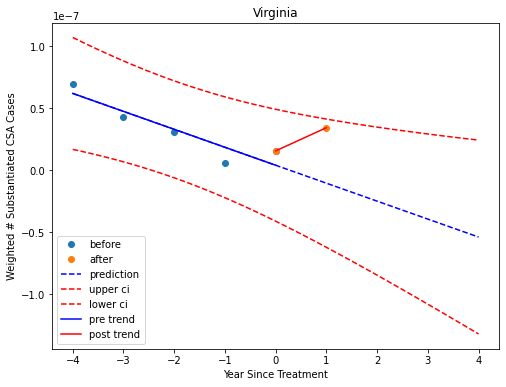

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning:

divide by zero encountered in double_scalars



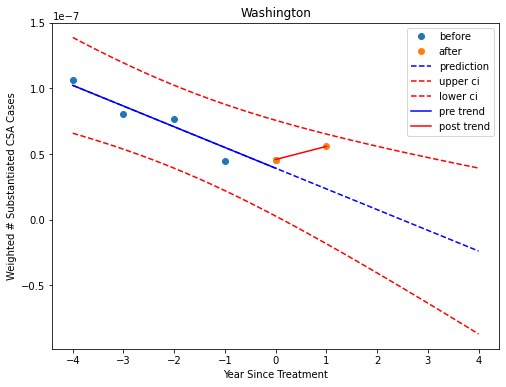

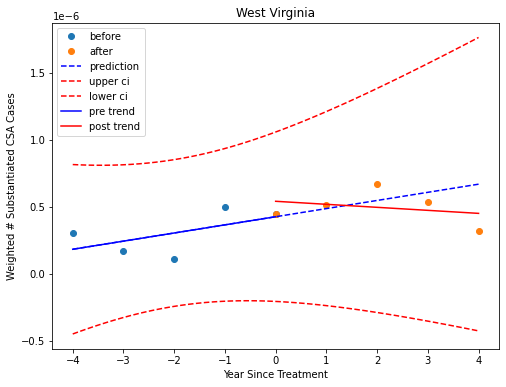

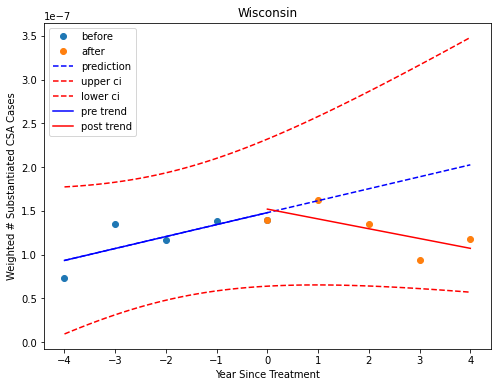

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning:

divide by zero encountered in double_scalars



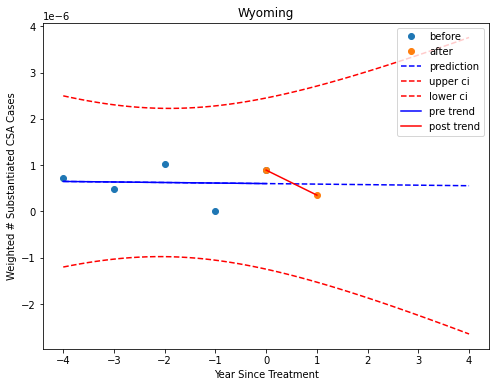

In [96]:
# Create a smaller subset of main df
parallel_df = df[['STATE', 'Effective_Date', 'year', 'sub_csa_cases', 
                  'median_household_income', 'pop', 'Unemployment_rate']].copy()

# Weight 'sub_csa_cases' on the demographic info
parallel_df['csa_weighted'] = parallel_df['sub_csa_cases'] * (1/parallel_df['pop']) * (1/parallel_df['median_household_income']) * parallel_df['Unemployment_rate']

parallel_df = parallel_df.rename(columns={"year": "yrs"})
parallel_df['year'] = pd.to_datetime(parallel_df['Effective_Date']).dt.year
parallel_df['year'] = parallel_df['year'].replace({2019: np.nan})
parallel_df['year'] = parallel_df['year'].replace({2020: np.nan})

# # Create control subset of main df and format
control_df = parallel_df[parallel_df['year'].isnull()]
control_df['offset_year'] = control_df['yrs'] - 2009
control_df['label'] = 'Control'
# # Reduce dataset to just 4 years before and after treatment
values = [-4, -3, -2, -1, 0 , 1, 2, 3, 4]
control_df = control_df[control_df['offset_year'].isin(values)]

# Create treatment subset of main df and format
treatment_df = parallel_df[~parallel_df['year'].isnull()]
treatment_df['offset_year'] = treatment_df['yrs'] - treatment_df['year']
treatment_df['label'] = 'Treatment'
# Reduce dataset to just 4 years before and after treatment
treatment_df = treatment_df[treatment_df['offset_year'].isin(values)]

# append the 2 dataframes together for ease of visualization
final_parallel_df = treatment_df.append(control_df, ignore_index=True)
final_parallel_df['treatment_year'] = 0

import statsmodels.stats.api as sms

def did_regression(state_df):
  pre_df = state_df[state_df['offset_year'] < 0][['offset_year', 'csa_weighted']]
  post_df = state_df[state_df['offset_year'] >= 0][['offset_year', 'csa_weighted']]

  pre_m, pre_b = np.polyfit(pre_df['offset_year'], pre_df['csa_weighted'], 1)
  post_m, post_b = np.polyfit(post_df['offset_year'], post_df['csa_weighted'], 1)

  lower_ci, upper_ci = sms.DescrStatsW(pre_df['csa_weighted']).tconfint_mean()
  time_point = 4
  estimated_csas = post_m * time_point + post_b
  predicted_csas = pre_m * time_point + pre_b
  negligible_change = predicted_csas - lower_ci <= estimated_csas and estimated_csas <= predicted_csas + upper_ci

  return pd.Series({
      'state': state_df['STATE'].iloc[0],
      'pre_m': pre_m,
      'pre_b': pre_b,
      'post_m': post_m,
      'post_b': post_b,
      'upper_ci': upper_ci,
      'lower_ci': lower_ci,
      'not_significant_change': negligible_change,
  })

ci_df = final_parallel_df.groupby(by='STATE').apply(did_regression)

%matplotlib inline

import statsmodels.api as sm

for state in sorted(final_parallel_df['STATE'].unique()):
  state_df = final_parallel_df[final_parallel_df['STATE'] == state]
  pre_df = state_df[state_df['offset_year'] <= 0]
  post_df = state_df[state_df['offset_year'] >= 0]

  x_pre, y_pre = pre_df['offset_year'], pre_df['csa_weighted']
  x_post, y_post = post_df['offset_year'], post_df['csa_weighted']

  pre_model = sm.OLS(y_pre, sm.add_constant(x_pre))
  pre_result = pre_model.fit()

  x_pred = np.linspace(-4, 4)
  pred_ols = pre_result.get_prediction(sm.add_constant(x_pred))
  summary = pred_ols.summary_frame()
  iv_l = summary['obs_ci_lower']
  iv_u = summary['obs_ci_upper']
  mean_y = summary['mean']

  post_model = sm.OLS(y_post, sm.add_constant(x_post))
  post_result = post_model.fit()
  post_ols = post_result.get_prediction(sm.add_constant(x_post))
  post_mean_y = post_ols.summary_frame()['mean']

  fig, ax = plt.subplots(figsize=(8, 6))
  plt.title(state)
  plt.xlabel('Year Since Treatment')
  plt.ylabel('Weighted # Substantiated CSA Cases')
  ax.plot(x_pre, y_pre, "o", label="before")
  ax.plot(x_post, y_post, "o", label="after")
  ax.plot(x_pred, mean_y, 'b--', label="prediction")
  ax.plot(x_pred, iv_u, "r--", label="upper ci")
  ax.plot(x_pred, iv_l, "r--", label="lower ci")
  ax.plot(x_pre, pre_result.fittedvalues, "b-", label="pre trend")
  ax.plot(x_post, post_mean_y, "r-", label="post trend")
  ax.legend(loc="best")

  plt.show()

In [97]:
final_parallel_df[final_parallel_df['STATE'] == 'California']

STATE Effective_Date   yrs  sub_csa_cases  median_household_income  \
16  California     2014-12-01  2010         6930.0                    54283   
17  California     2014-12-01  2011         5876.0                    53367   
18  California     2014-12-01  2012         7617.0                    57020   
19  California     2014-12-01  2013         3540.0                    60794   
20  California     2014-12-01  2014         1529.0                    60487   
21  California     2014-12-01  2015         6499.0                    63636   
22  California     2015-10-01  2016         6431.0                    66637   
23  California     2015-10-01  2017         6403.0                    70038   
24  California     2015-10-01  2018         6337.0                    70489   
25  California     2015-10-01  2019         7743.0                    80423   

         pop  Unemployment_rate  csa_weighted    year  offset_year      label  \
16  37253956               12.2  4.180775e-08  2014.0         -4.0  Treatment   
17  37638369               11.7  3.422662e-08  2014.0         -3.0  Treatment   
18  37948800               10.4  3.660935e-08  2014.0         -2.0  Treatment   
19  38260787                8.9  1.354499e-08  2014.0         -1.0  Treatment   
20  38596972                7.5  4.911945e-09  2014.0          0.0  Treatment   
21  38918045                6.2  1.626988e-08  2014.0          1.0  Treatment   
22  39167117                5.5  1.355202e-08  2015.0          1.0  Treatment   
23  39358497                4.8  1.114943e-08  2015.0          2.0  Treatment   
24  39461588                4.2  9.568351e-09  2015.0          3.0  Treatment   
25  39512223                4.2  1.023403e-08  2015.0          4.0  Treatment   

    treatment_year  
16               0  
17               0  
18               0  
19               0  
20               0  
21               0  
22               0  
23               0  
24               0  
25               0

In [98]:
# Pull out any states in the 51 that may have done something significant
ci_df.loc[ci_df['not_significant_change'] == False]

state         pre_m         pre_b  \
STATE                                                                    
Alabama                            Alabama -8.798814e-08 -3.644488e-08   
Arizona                            Arizona  2.074722e-08  9.114326e-08   
Arkansas                          Arkansas -2.094068e-08  8.370304e-08   
Connecticut                    Connecticut  1.202315e-08  1.346585e-07   
District of Columbia  District of Columbia  4.101071e-07  2.194281e-06   
Florida                            Florida -2.138742e-09  9.996547e-09   
Georgia                            Georgia -3.296904e-09  4.855802e-08   
Hawaii                              Hawaii  1.529600e-08  1.552213e-07   
Illinois                          Illinois  1.020669e-08  9.281420e-08   
Indiana                            Indiana  7.772449e-08  3.523376e-07   
Kansas                              Kansas -5.712885e-08  4.971059e-08   
Maryland                          Maryland -2.172839e-08 -8.107950e-09   
Massachusetts                Massachusetts  1.795800e-08  1.072436e-07   
Michigan                          Michigan  1.322747e-08  1.373390e-07   
Minnesota                        Minnesota  1.803404e-08  9.984308e-08   
Mississippi                    Mississippi -2.608458e-08  2.217743e-07   
Missouri                          Missouri  1.461926e-08  1.173810e-07   
Montana                            Montana -1.936671e-07 -1.331514e-07   
Nebraska                          Nebraska  4.756668e-08  2.215236e-07   
Nevada                              Nevada -5.121717e-08  2.764843e-08   
New Jersey                      New Jersey  1.403277e-08  7.155945e-08   
New York                          New York -7.807105e-10  1.438376e-08   
North Carolina              North Carolina -1.588722e-08  3.085326e-10   
Pennsylvania                  Pennsylvania  1.578903e-08  9.061944e-08   
Rhode Island                  Rhode Island -3.344130e-07 -1.441845e-07   
South Carolina              South Carolina -6.921033e-09  1.260271e-07   
Texas                                Texas  6.143076e-09  3.534343e-08   
Virginia                          Virginia -2.027181e-08 -1.329458e-08   
Washington                      Washington -1.907004e-08  2.929566e-08   
West Virginia                West Virginia  5.189475e-08  4.002788e-07   
Wisconsin                        Wisconsin  1.791545e-08  1.607482e-07   
Wyoming                            Wyoming -1.569491e-07  1.654927e-07   

                            post_m        post_b      upper_ci      lower_ci  \
STATE                                                                          
Alabama              -1.768597e-08  1.296906e-07  4.363144e-07 -6.926344e-08   
Arizona              -1.981152e-08  1.465661e-07  9.543090e-08 -1.688048e-08   
Arkansas              2.431413e-08  3.937334e-07  2.480740e-07  2.403543e-08   
Connecticut          -2.301818e-08  1.486386e-07  2.753596e-07 -6.615846e-08   
District of Columbia -1.506315e-07  1.569343e-06  2.271938e-06  6.608777e-08   
Florida              -1.193378e-08  8.643296e-08  2.693279e-08  3.754016e-09   
Georgia              -1.409859e-08  4.214119e-08  1.181686e-07 -4.568004e-09   
Hawaii               -4.703606e-08  3.226812e-07  2.004437e-07  3.351896e-08   
Illinois             -1.259911e-08  7.381236e-08  1.147108e-07  1.988417e-08   
Indiana              -1.378564e-08  1.030001e-07  3.304511e-07 -1.439828e-08   
Kansas               -4.112793e-10  2.960640e-07  3.127225e-07  7.234289e-08   
Maryland              9.316409e-10  1.787209e-08  9.229764e-08  1.284132e-10   
Massachusetts        -4.390567e-09  1.013072e-07  1.408843e-07 -1.618709e-08   
Michigan             -3.567521e-08  1.592708e-07  2.550832e-07 -4.654269e-08   
Minnesota            -4.970861e-09  5.741406e-08  1.186333e-07 -9.117386e-09   
Mississippi          -9.288977e-08  3.635073e-07  7.058349e-07 -1.318634e-07   
Missouri              1.173678e-08  9.490443e-08  1.611773e-07  4.884220e-10   


In [99]:
# Lets look at the first 6 states as individual treatment groups
# Blue is treatment group (state) Green is control (average of states with no CSA law)

# Pull out only the first 6 states to enact the law
top_6_states = ['Texas', 'Vermont', 'Michigan', 'Indiana', 'Illinois', 'Mississippi']
top_6_df = df[['STATE', 'year', 'Effective_Date', 'sub_csa_cases']].copy()
top_6_df = top_6_df.rename(columns={"year": "yrs"})

# Create a smaller subset of main df and format
top_6_df = top_6_df[top_6_df['STATE'].isin(top_6_states)]
top_6_df['year'] = pd.to_datetime(top_6_df['Effective_Date']).dt.year
top_6_df['yrs'] = top_6_df['yrs'].apply(str)

# Create smaller subset of main df and format
parallel_df = df[['STATE', 'Effective_Date', 'year', 'sub_csa_cases']].copy()
parallel_df = parallel_df.rename(columns={"year": "yrs"})
parallel_df['year'] = pd.to_datetime(parallel_df['Effective_Date']).dt.year
parallel_df['year'] = parallel_df['year'].replace({2019: np.nan})
parallel_df['year'] = parallel_df['year'].replace({2020: np.nan})

# # Create control subset of main df and format
control_df = parallel_df[parallel_df['year'].isnull()]
control_cases_by_year = control_df.groupby(by=['yrs']).mean('sub_csa_cases')
control_cases_by_year.drop(columns=['year'], inplace=True)
control_cases_by_year.reset_index(inplace=True)

# Create a function that will create a line chart for a given state
def create_chart(state):
  df = top_6_df[top_6_df['STATE'] == state]
  enact_year = df['year'].iloc[0]
  df['ey'] = enact_year
  df['ey'] = df['ey'].apply(str)
  df['yrs'] = df['yrs'].apply(int)
  df['offset_year'] = df['yrs'] - df['year']
  df['rule'] = 0
  df['Legend'] = 'Year of Enactment'
  df['Treatment'] = "Treatment"

  local_control = control_cases_by_year.copy()
  local_control['offset_year'] = local_control['yrs'] - enact_year
  local_control['Control'] = 'Control'

  # treatment line
  df_chart = alt.Chart(df[['offset_year','sub_csa_cases', 'Treatment']]).mark_line(size=3).encode(
      x=alt.X('offset_year', title='Year Since Treatment'),
      y=alt.Y('sub_csa_cases', title='# Substantiated CSA Cases'),
      shape=alt.Shape('Treatment', legend=alt.Legend(title='Legend'))
  )

  # control year
  df_chart2 = alt.Chart(local_control[['offset_year','sub_csa_cases', 'Control']]).mark_line(color='green', size=3).encode(
        x=alt.X('offset_year'),
        y=alt.Y('sub_csa_cases'),
        size=alt.Size('Control', legend=alt.Legend(title=None))
        )

  df_rule = alt.Chart(df[['rule', 'Legend']]).mark_rule().encode(
      x='rule',
      size=alt.value(2),
      opacity=alt.Opacity('Legend', legend=alt.Legend(title=None))
  )

  final_vis = df_chart + df_chart2 + df_rule
  final_vis = final_vis.properties(title=f'{state}', height=200, width=250)

  return final_vis

# Create a plot for each of the top 6 states
texas_vis = create_chart('Texas')
vermont_vis = create_chart('Vermont')
michigan_vis = create_chart('Michigan')

indiana_vis = create_chart('Indiana')
illinois_vis = create_chart('Illinois')
miss_vis = create_chart('Mississippi')

# hconcat the state visuals into rows
row1 = texas_vis | vermont_vis | michigan_vis
row2 = indiana_vis | illinois_vis | miss_vis

# vconcat the rows to create a small multiples plot
final = (row1 & row2).properties(
    title='Number of CSA Cases Over Time in the First 6 States to Enforce a Law'
    ).configure_title(anchor='middle', fontSize=15,).configure_point(
    size=10
)

# Show the visual    
final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

alt.VConcatChart(...)

##Statistical evaluation of parallel trends assumption

Here is our research on the basic statistical tests for the parallel trends assumption, but we actually conduct the pretrend calculation using the R  dataframe right before the Callaway calculation below

In [100]:
#articles
#https://diff.healthpolicydatascience.org/
#https://blogs.worldbank.org/impactevaluations/revisiting-difference-differences-parallel-trends-assumption-part-i-pre-trend
#https://blogs.worldbank.org/impactevaluations/revisiting-difference-differences-parallel-trends-assumption-part-ii-what-happens
#https://scholar.harvard.edu/files/jroth/files/roth_jmp_honestparalleltrends_main.pdf
#

##Event studies for parallel trends assumption

Three different places below we do event studies for the insights they might produce

#Regression analysis

##Regression functions

In [101]:
#define variables
dropped_vars = ('District_of_Columbia_trend', 'Vermont_trend',
                  'West_Virginia_trend', 'Wisconsin_trend', 'Wyoming_trend')
cols = pd.Series(df.columns)
trend_cols = set(cols[cols.str.contains('trend$')])
lintrend = df[trend_cols - set(dropped_vars)]

lintrend = set(cols[cols.str.contains('trend$')])

xvar = ('Unemployment_rate', 'median_household_income')

edu = ('Required', 'Some_All_Staff', 'PK_5', 'G6_12', 'Opt_Out') 

laws = ('Screening', 'Criminalization', 'Task_Force', 'Posters')


In [102]:
 #define formula for DiD regression
#https://stackoverflow.com/questions/33712400/statsmodels-ols-clustered-standard-errors-not-accepting-series-from-df
def regress_plain(y):
  dd_formula = y+ " ~ post + C(year) + C(sid)"

  #Fixed effect regression using post as treatment variable 
  dd_reg_1 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit() 
  return dd_reg_1

In [103]:
def regress_xvar(y):
#define formula for DiD regression
  dd_formula = y+" ~ {} + post + C(year) + C(sid)".format(
      "+".join(xvar))

  #Fixed effect regression using post as treatment variable 
  dd_reg_2 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit()  # cov_type='cluster', cov_kwds={'groups':df['sid']}
  return dd_reg_2

In [104]:
def regress_edu(y):
  #define formula for DiD regression
  dd_formula = y+" ~ {} + {} + post + C(year) + C(sid)".format("+".join(xvar), "+".join(edu))  

  #Fixed effect regression using post as treatment variable 
  dd_reg_3 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit()  # cov_type='cluster', cov_kwds={'groups':df['sid']}
  return dd_reg_3

In [105]:
def regress_laws(y):
  #define formula for DiD regression
  dd_formula = y+" ~ {} + {} + post + C(year) + C(sid)".format("+".join(xvar), "+".join(laws)) #, "+".join(edu))

  #Fixed effect regression using post as treatment variable 
  dd_reg_4 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit()  # cov_type='cluster', cov_kwds={'groups':df['sid']}
  return dd_reg_4

In [106]:
def regress_lintrend(y):
  dd_formula = y+" ~ {} + {} + {} + post + C(year) + C(sid)".format("+".join(xvar), "+".join(laws), "+".join(lintrend)) #, "+".join(edu)

  #Fixed effect regression using post as treatment variable 
  dd_reg_5 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit()  # cov_type='cluster', cov_kwds={'groups':df['sid']}
  return dd_reg_5

In [107]:
def regress_chart(a,b,d,e):

  #pull it all together
  dd_table = Stargazer([a,b,d,e])
  dd_table.covariate_order(['post[T.1.0]', 
  'Unemployment_rate',
  'median_household_income',
  'Screening[T.1.0]',
  'Criminalization[T.1.0]',
  'Task_Force[T.1.0]',
  'Posters[T.1.0]',
  'Missouri_trend',
  'Massachusetts_trend',
  'Maryland_trend',
  'South_Dakota_trend',
  'Arkansas_trend',
  'Vermont_trend',
  'New_York_trend',
  'Texas_trend',
  'Georgia_trend',
  'Virginia_trend',
  'Kansas_trend',
  'Ohio_trend',
  'New_Hampshire_trend',
  'Wyoming_trend',
  'Alabama_trend',
  'Oklahoma_trend',
  'Kentucky_trend',
  'Rhode_Island_trend',
  'Connecticut_trend',
  'Tennessee_trend',
  'Alaska_trend',
  'Idaho_trend',
  'Mississippi_trend',
  'Wisconsin_trend',
  'Iowa_trend',
  'California_trend',
  'Florida_trend',
  'Maine_trend',
  'Hawaii_trend',
  'Washington_trend',
  'Delaware_trend',
  'Montana_trend',
  'Nebraska_trend',
  'Minnesota_trend',
  'Utah_trend',
  'Pennsylvania_trend',
  'Arizona_trend',
  'Michigan_trend',
  'Louisiana_trend',
  'Illinois_trend',
  'Colorado_trend',
  'New_Jersey_trend',
  'West_Virginia_trend',
  'Nevada_trend',
  'South_Carolina_trend',
  'Indiana_trend',
  'New_Mexico_trend',
  'North_Carolina_trend',
  'District_of_Columbia_trend',
  'Intercept',
  'C(year)[T.2006]',
  'C(year)[T.2007]',
  'C(year)[T.2008]',
  'C(year)[T.2009]',
  'C(year)[T.2010]',
  'C(year)[T.2011]',
  'C(year)[T.2012]',
  'C(year)[T.2013]',
  'C(year)[T.2014]',
  'C(year)[T.2015]',
  'C(year)[T.2016]',
  'C(year)[T.2017]',
  'C(year)[T.2018]',
  'C(year)[T.2019]',
  'C(sid)[T.1]',
  'C(sid)[T.2]',
  'C(sid)[T.3]',
  'C(sid)[T.4]',
  'C(sid)[T.5]',
  'C(sid)[T.6]',
  'C(sid)[T.7]',
  'C(sid)[T.8]',
  'C(sid)[T.9]',
  'C(sid)[T.10]',
  'C(sid)[T.11]',
  'C(sid)[T.12]',
  'C(sid)[T.13]',
  'C(sid)[T.14]',
  'C(sid)[T.15]',
  'C(sid)[T.16]',
  'C(sid)[T.17]',
  'C(sid)[T.18]',
  'C(sid)[T.19]',
  'C(sid)[T.20]',
  'C(sid)[T.21]',
  'C(sid)[T.22]',
  'C(sid)[T.23]',
  'C(sid)[T.24]',
  'C(sid)[T.25]',
  'C(sid)[T.26]',
  'C(sid)[T.27]',
  'C(sid)[T.28]',
  'C(sid)[T.29]',
  'C(sid)[T.30]',
  'C(sid)[T.31]',
  'C(sid)[T.32]',
  'C(sid)[T.33]',
  'C(sid)[T.35]',
  'C(sid)[T.36]',
  'C(sid)[T.38]',
  'C(sid)[T.39]',
  'C(sid)[T.40]',
  'C(sid)[T.41]',
  'C(sid)[T.42]',
  'C(sid)[T.43]',
  'C(sid)[T.44]',
  'C(sid)[T.45]',
  'C(sid)[T.46]',
  'C(sid)[T.47]',
  'C(sid)[T.48]',
  'C(sid)[T.49]',
  'C(sid)[T.50]'
  ])
  return dd_table

In [108]:
def regress(y):
  a =regress_plain(y)
  b =regress_xvar(y)
  d =regress_laws(y)
  e =regress_lintrend(y)
  f = regress_chart(a,b,d,e)
  return f

##Run regressions on every Y

###y = sub_csa_cases

In [109]:
regress('sub_csa_cases')

###y = sub_ca_cases

In [110]:
regress('sub_ca_cases')

###y = sub_rep_csa_ratio

In [111]:
regress('sub_rep_csa_ratio')

###y = rep_csa_cases

In [112]:
regress('rep_csa_cases')

###y =  sub_ca_yc

In [113]:
#https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
regress('sub_ca_yc')

###y = sub_csa_yc

In [114]:
regress('sub_csa_yc')

###y = rep_csa_inc

In [115]:
regress("rep_csa_inc")

#Regression event study for revisiting parallel trends assumption

In [116]:
#create effective data column
def year_con(x):
  if type(x) != float:
    result = x.year
  else:
    result = 0
  return result

df['Effective_Date'] = df['Effective_Date'].apply(year_con)

In [117]:
##this creates the leads and lags we will use later, based on when the law is adopted
#the use of leads and lags are used to produce event studies

df['time_til'] = df['year'] - df['Effective_Date']

df['lead1'] = df['time_til'] == -1
df['lead2'] = df['time_til'] == -2
df['lead3'] = df['time_til'] == -3
df['lead4'] = df['time_til'] == -4
df['lead5'] = df['time_til'] == -5
df['lead6'] = df['time_til'] == -6
df['lead7'] = df['time_til'] == -7
df['lead8'] = df['time_til'] == -8
df['lead9'] = df['time_til'] == -9
df['lag0'] = df['time_til'] == 0 
df['lag1'] = df['time_til'] == 1 
df['lag2'] = df['time_til'] == 2 
df['lag3'] = df['time_til'] == 3 
df['lag4'] = df['time_til'] == 4 
df['lag5'] = df['time_til'] == 5 


In [118]:
#15 year event study
formula = "sub_csa_cases ~ lead1 + lead2 + lead3 + lead4 + lead5 + lead6 + lead7 + lead8 + lead9 + lag1 + lag2 + lag3 + lag4 + lag5 + C(year) + C(sid)"
event_study_formula = smf.wls(formula, data = df, weights = df['popwt']).fit() 
event_study_formula.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          sub_csa_cases   R-squared:                       0.145
Model:                            WLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.474
Date:                Tue, 14 Dec 2021   Prob (F-statistic):            0.00767
Time:                        03:41:03   Log-Likelihood:                -6911.6
No. Observations:                 735   AIC:                         1.398e+04
Df Residuals:                     658   BIC:                         1.433e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3770.0002    824.971      4.570      0.000    2150.107    5389.893
lead1[T.True]    -124.9244    500.381     -0.250      0.803   -1107.460     857.612
lead2[T.True]     667.6687    502.616      1.328      0.185    -319.255    1654.593
lead3[T.True]     484.8118    501.828      0.966      0.334    -500.566    1470.189
lead4[T.True]    -546.6134    497.886     -1.098      0.273   -1524.251     431.024
lead5[T.True]     577.2100    521.326      1.107      0.269    -446.454    1600.874
lead6[T.True]      89.9304    525.603      0.171      0.864    -942.132    1121.992
lead7[T.True]     286.2902    525.076      0.545      0.586    -744.736    1317.317
lead8[T.True]    -157.8528    548.520     -0.288      0.774   -1234.914     919.208
lead9[T.True]    -380.7431    564.240     -0.675      0.500   -1488.671     727.185
lag1[T.True]     1674.8493    519.572      3.224      0.001     654.631    2695.068
lag2[T.True]      128.4238    588.539      0.218      0.827   -1027.218    1284.065
lag3[T.True]       91.4356    611.023      0.150      0.881   -1108.354    1291.225
lag4[T.True]      288.5345    621.216      0.464      0.642    -931.270    1508.339
lag5[T.True]     -612.0796    745.063     -0.822      0.412   -2075.067     850.907
C(year)[T.2006]   194.9398    508.618      0.383      0.702    -803.770    1193.650
C(year)[T.2007]  -292.8821    509.591     -0.575      0.566   -1293.503     707.739
C(year)[T.2008]   255.8540    512.518      0.499      0.618    -750.514    1262.222
C(year)[T.2009]  1060.3527    505.939      2.096      0.036      66.902    2053.803
C(year)[T.2010]  1057.6920    503.830      2.099      0.036      68.383    2047.001
C(year)[T.2011]   121.3953    524.933      0.231      0.817    -909.350    1152.140
C(year)[T.2012]   957.3943    525.262      1.823      0.069     -73.998    1988.787
C(year)[T.2013]   175.9790    530.192      0.332      0.740    -865.093    1217.051
C(year)[T.2014]   416.2544    515.803      0.807      0.420    -596.564    1429.072
C(year)[T.2015]  -124.7978    522.083     -0.239      0.811   -1149.946     900.351
C(year)[T.2016]    72.4074    527.922      0.137      0.891    -964.208    1109.023
C(year)[T.2017]   590.5415    532.906      1.108      0.268    -455.860    1636.943
C(year)[T.2018]   226.1086    529.234      0.427      0.669    -813.083    1265.300
C(year)[T.2019]  1298.7374    525.554      2.471      0.014     266.773    2330.702
C(sid)[T.1]       -95.4020   1991.453     -0.048      0.962   -4005.770    3814.966
C(sid)[T.2]      -348.4653    975.280     -0.357      0.721   -2263.502    1566.571
C(sid)[T.3]      1165.3347   1190.724      0.979      0.328   -1172.742    3503.411
C(sid)[T.4]       811.8100    762.530      1.065      0.287    -685.475    2309.096
C(sid)[T.5]       -35.3320   1024.887     -0.034      0.973

In [119]:
#this converts the output of the summary coeffients for use in the chart

leads = ['lead9[T.True]', 'lead8[T.True]', 'lead7[T.True]', 'lead6[T.True]', 'lead5[T.True]', 'lead4[T.True]', 'lead3[T.True]', 'lead2[T.True]', 'lead1[T.True]']
lags = ['lag1[T.True]', 'lag2[T.True]', 'lag3[T.True]', 'lag4[T.True]', 'lag5[T.True]']

leadslags_plot = pd.DataFrame({
    'sd' : np.concatenate([np.sqrt(np.diag(event_study_formula.cov_params().loc[leads][leads])), np.array([0]), np.sqrt(np.diag(event_study_formula.cov_params().loc[lags][lags]))]),
    'mean':  np.concatenate([event_study_formula.params[leads], np.array([0]), event_study_formula.params[lags]]),
    'label': np.arange(-9, 6)}) 

leadslags_plot['lb'] = leadslags_plot['mean'] - leadslags_plot['sd']*1.96
leadslags_plot['ub'] = leadslags_plot['mean'] + leadslags_plot['sd']*1.96

In [120]:
#create mean line
red = sum(event_study_formula.params[lags]) / len(event_study_formula.params[lags])
red

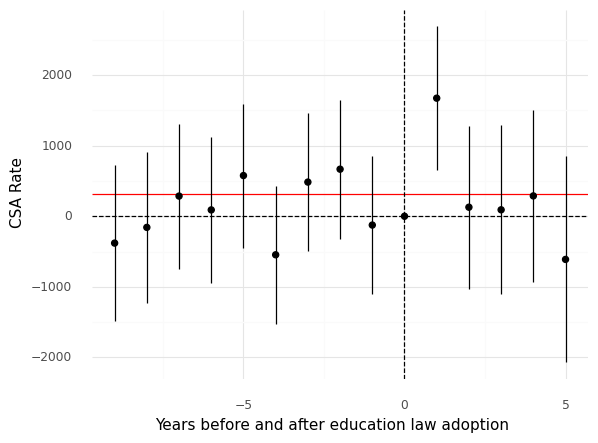

<ggplot: (8782006315909)>

In [121]:
# This version has a point-range at each estimated lead or lag
# the average of the leads should be zero, so a non zero average of all would be pulled up by the lags
p.ggplot(leadslags_plot, p.aes(x = 'label', y = 'mean',
             ymin = 'lb', 
             ymax = 'ub')) +\
    p.geom_hline(yintercept = red, color = "red") +\
    p.geom_pointrange() +\
    p.theme_minimal() +\
    p.xlab("Years before and after education law adoption") +\
    p.ylab("CSA Rate") +\
    p.geom_hline(yintercept = 0,
             linetype = "dashed") +\
    p.geom_vline(xintercept = 0,
             linetype = "dashed")

#Creating a new dataframe in feather format that R can use for Bacon and Calloway

In [122]:
selected_columns = df[["sid","sub_csa_cases", 'post', 'year', 'Effective_Date', 'Screening', 'Criminalization',  'Task_Force', 'Posters', 'median_household_income', 'sub_ca_cases', 'sub_rep_csa_ratio', 'rep_csa_cases','Unemployment_rate', 'sub_csa_yc', 'sub_ca_yc', 'pop', 'rep_csa_inc', 'popwt']] #
R_df = selected_columns.copy()


In [123]:
#have to deal with Indiana and California where the same state has two rows
R_df.loc[R_df['sid'] == 4, 'Effective_Date'] = 2014
R_df.loc[R_df['sid'] == 14, 'Effective_Date'] = 2012

In [124]:
R_df['Unemployment_rate'] = R_df['Unemployment_rate'].apply(lambda x : x * 100)
R_df['pop'] = R_df['pop'].apply(lambda x : x / 10000)
R_df['median_household_income'] = R_df['median_household_income'].apply(lambda x : x / 100)
R_df = R_df.round(0)

In [125]:
R_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 734
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sid                      735 non-null    int64  
 1   sub_csa_cases            735 non-null    float64
 2   post                     735 non-null    object 
 3   year                     735 non-null    int64  
 4   Effective_Date           735 non-null    int64  
 5   Screening                735 non-null    object 
 6   Criminalization          735 non-null    object 
 7   Task_Force               735 non-null    object 
 8   Posters                  735 non-null    object 
 9   median_household_income  735 non-null    float64
 10  sub_ca_cases             735 non-null    float64
 11  sub_rep_csa_ratio        735 non-null    float64
 12  rep_csa_cases            735 non-null    float64
 13  Unemployment_rate        735 non-null    float64
 14  sub_csa_yc               7

In [126]:
R_df = R_df.astype(int) 

In [127]:
get_ipython().run_cell_magic(
"R",
"-i R_df",
'''
library(feather)
path <- "final_df.feather"
write_feather(R_df, path)
R_df <- read_feather(path)
'''
)

In [128]:
%%R
R_df

# A tibble: 735 × 19
     sid sub_csa_cases  post  year Effective_Date Screening Criminalization
   <int>         <int> <int> <int>          <int>     <int>           <int>
 1     0           931     0  2005           2015         0               0
 2     0          5262     0  2006           2015         0               0
 3     0          6061     0  2007           2015         0               0
 4     0          5210     0  2008           2015         0               0
 5     0          3875     0  2009           2015         0               0
 6     0          1607     0  2010           2015         0               0
 7     0          7818     0  2011           2015         0               0
 8     0          2359     0  2012           2015         0               0
 9     0          8227     0  2013           2015         0               1
10     0           529     0  2014           2015         0               1
# … with 725 more rows, and 12 more variables: Task_Force <int>, Po

#Bacon decomposition

In [129]:
#https://cran.r-project.org/web/packages/bacondecomp/vignettes/bacon.html
#https://towardsdatascience.com/how-to-use-r-in-google-colab-b6e02d736497
#https://towardsdatascience.com/how-to-install-packages-in-r-google-colab-423e8928cd2e
#https://medium.com/@ezzaouia/how-to-use-r-and-python-with-google-colaboratory-notebook-ebc4774d48a
#https://github.com/evanjflack/bacondecomp

In [130]:
#https://stackoverflow.com/questions/68055242/how-do-i-solve-the-parsing-error-when-using-rpy2
#https://github.com/rpy2/rpy2/issues/813
#https://blog.rstudio.com/2016/03/29/feather/

In [131]:
get_ipython().run_cell_magic(
"R",
"-i R_df",
'''
library(bacondecomp)

df_bacon <- bacon(sub_csa_cases ~ post,
                  data = R_df,
                  id_var = "sid",
                  time_var = "year")

coef_bacon <- sum(df_bacon$estimate * df_bacon$weight)
print(paste("Weighted sum of decomposition =", round(coef_bacon, 4)))

fit_tw <- lm(sub_csa_cases ~ post + factor(sid) + factor(year), 
             data = R_df)
print(paste("Two-way FE estimate =", round(fit_tw$coefficients[2], 4)))
'''
)

                      type  weight    avg_est
1 Earlier vs Later Treated 0.22274    3.14056
2 Later vs Earlier Treated 0.06912  532.60082
3     Treated vs Untreated 0.70815 -568.06558
[1] "Weighted sum of decomposition = -364.7622"
[1] "Two-way FE estimate = -364.7622"


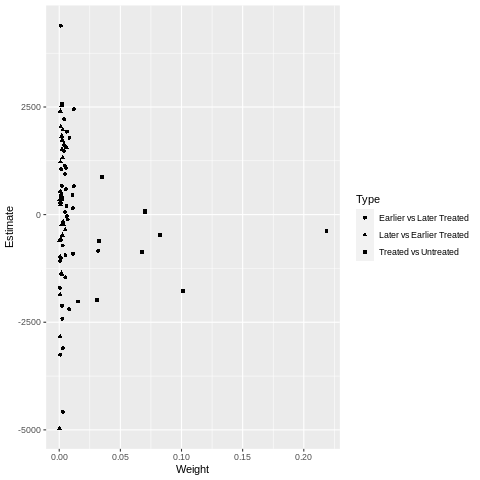

In [132]:
%%R
library(ggplot2)

ggplot(df_bacon) +
  aes(x = weight, y = estimate, shape = factor(type)) +
  labs(x = "Weight", y = "Estimate", shape = "Type") +
  geom_point()

#Revisiting the parallel trends assumption using Callaway for pre-trend testing

In [133]:
#https://bcallaway11.github.io/did/articles/pre-testing.html
#https://bcallaway11.github.io/did/reference/conditional_did_pretest.html
#https://github.com/bcallaway11/did/blob/master/R/conditional_did_pretest.R

How to conduct pre-tests in DiD setups using the did package.

One appealing feature of many DiD applications with multiple periods is that the researcher can pre-test the parallel trends assumptions. The idea here is simple: although one can not always test whether parallel trends itself holds, one can check if it holds in periods before treated units actually become treated.

Importantly, this is just a pre-test; it is different from an actual test. Whether or not the parallel trends assumption holds in pre-treatment periods does not actually tell you if it holds in the current period (and this is when you need it to hold!). It is certainly possible for the identifying assumptions to hold in previous periods but not hold in current periods; it is also possible for identifying assumptions to be violated in previous periods but for them to hold in current periods. That being said, we view the pre-test as a piece of evidence on the credibility of the DiD design in a particular application.

In this vignette, we demonstrate that the approach used in the did package for pre-testing may work substantially better than the more common “event study regression”.


In [134]:
%%R
head(R_df)

  sid sub_csa_cases post year Effective_Date Screening Criminalization
0   0           931    0 2005           2015         0               0
1   0          5262    0 2006           2015         0               0
2   0          6061    0 2007           2015         0               0
3   0          5210    0 2008           2015         0               0
4   0          3875    0 2009           2015         0               0
5   0          1607    0 2010           2015         0               0
  Task_Force Posters median_household_income sub_ca_cases sub_rep_csa_ratio
0          0       0                     372        37514                59
1          0       0                     380        97098                 3
2          0       0                     422         7100                 1
3          0       0                     445       109084                 9
4          0       0                     400        10962                11
5          0       0                     409   

In [135]:
#the following two cells do not run properly with the randomized data and are commented out intentionally

In [136]:
#An integrated moments test for the conditional parallel trends assumption holding in all pre-treatment time periods for all groups
# %%R
# library(did)
# cdp <- conditional_did_pretest(yname = 'sub_csa_cases',
#               gname = "Effective_Date",
#               idname = "sid",
#               tname = "year",
#               xformla = ~Unemployment_rate + median_household_income, # + pop,  # + Posters + Task_Force + Criminalization + Screening
#               data = R_df,
#               panel = TRUE,
#               allow_unbalanced_panel = FALSE,
#               control_group = c("nevertreated", "notyettreated"),
#               weightsname = 'popwt', #NULL,
#               alp = 0.05,
#               bstrap = TRUE,
#               cband = TRUE,
#               biters = 1000,
#               clustervars = 'sid', #NULL,
#               est_method = 'reg', #"ipw",
#               print_details = FALSE,
#               pl = FALSE,
#               cores = 1)


In [137]:
# %%R
# summary(cdp)

#DID analysis re Callaway and Sant'Anna

In [138]:
#https://pedrohcgs.github.io/software/
#https://bcallaway11.github.io/did/
#https://bcallaway11.github.io/did/articles/did-basics.html

##y = sub_csa_cases

In [139]:
%%R
library(did)
out <- att_gt(yname = 'sub_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt', 
              alp = 0.05,
              cband = TRUE
              )

In [140]:
#https://causalinf.substack.com/p/callaway-and-santanna-dd-estimator
#https://pedrohcgs.github.io/posts/twfe
# ~1 is just a constant, but here is where we would add covariates--+ Screening + Criminalization + Task_Force + Posters


For some reason, criminalization leaves the numbers in but any of the other three produce many NA

In [141]:
%%R
summary(out)


Call:
att_gt(yname = "sub_csa_cases", tname = "year", idname = "sid", 
    gname = "Effective_Date", xformla = ~Unemployment_rate + 
        median_household_income + Criminalization, data = R_df, 
    panel = TRUE, allow_unbalanced_panel = FALSE, control_group = c("nevertreated", 
        "notyettreated"), weightsname = "popwt", alp = 0.05, 
    bstrap = TRUE, cband = TRUE, biters = 1000, clustervars = "sid", 
    est_method = "reg", print_details = FALSE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time    ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
  2009 2006   7401.1173  1317.1184     3772.7262  11029.5084 *
  2009 2007  -2707.8974  1409.5604    -6590.9474   1175.1526  
  2009 2008   3457.5537   817.2764     1206.1248  

In [142]:
%%R
out.simple <- aggte(out, type = "simple", na.rm = TRUE)
summary(out.simple)


Call:
aggte(MP = out, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


       ATT    Std. Error     [ 95%  Conf. Int.] 
 -270.4599      1192.435  -2607.589     2066.67 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


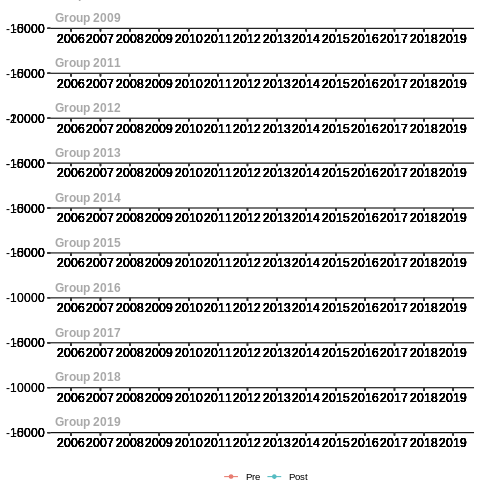

In [143]:
%%R
ggdid(out) #add ylim = c(-.3,.3) to control the y axis scale

In [144]:
%%R
out.gs <- aggte(out, type = "group", na.rm = TRUE)
summary(out.gs)


Call:
aggte(MP = out, type = "group", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on group/cohort aggregation:  
      ATT    Std. Error     [ 95%  Conf. Int.] 
 688.8494      713.4815  -709.5487    2087.247 


Group Effects:
 Group   Estimate Std. Error [95% Simult.  Conf. Band]  
  2009 -3395.0399   1306.608     -6423.381   -366.6991 *
  2011  2646.7119   1933.413     -1834.384   7127.8077  
  2012  2472.0217   3776.633     -6281.128  11225.1718  
  2013 -3898.2174   1161.985     -6591.365  -1205.0695 *
  2014   909.8255   1624.431     -2855.139   4674.7904  
  2015  1268.8416   2904.366     -5462.645   8000.3279  
  2016   274.4397   1473.464     -3140.627   3689.5063  
  2017  1818.2989   1392.286     -1408.620   5045.2176 

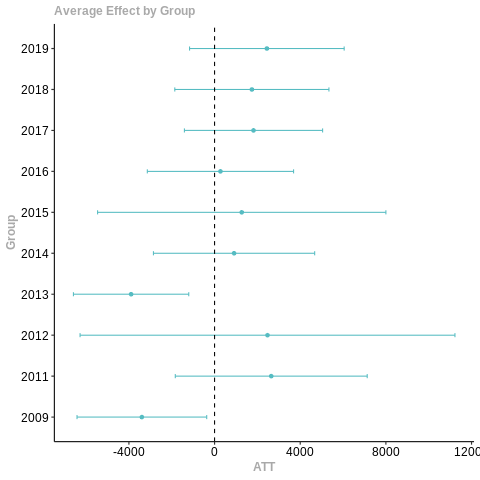

In [145]:
%%R
ggdid(out.gs)

In [146]:
%%R
out.ct <- aggte(out, type = "calendar", na.rm = TRUE)
summary(out.ct)


Call:
aggte(MP = out, type = "calendar", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on calendar time aggregation:  
       ATT    Std. Error     [ 95%  Conf. Int.] 
 -859.2925      1033.486  -2884.888    1166.303 


Time Effects:
 Time   Estimate Std. Error [95% Simult.  Conf. Band]  
 2009   315.2978   1312.478     -2881.910    3512.506  
 2010   243.5225   1415.757     -3205.272    3692.317  
 2011 -6640.4347   1631.241    -10614.150   -2666.719 *
 2012  -379.5053   3806.049     -9651.071    8892.060  
 2013 -1866.2505   1910.602     -6520.491    2787.990  
 2014 -1652.1476   2446.285     -7611.318    4307.023  
 2015  -837.6673   1815.254     -5259.640    3584.306  
 2016 -1562.0654   1155.507     -4376.889    1252.758  
 2

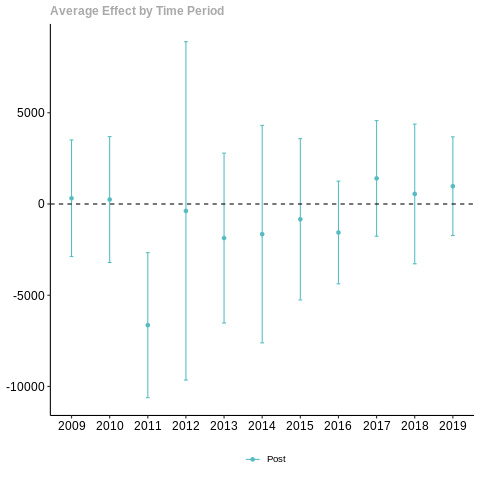

In [147]:
%%R
ggdid(out.ct)

##y = sub_rep_csa_ratio

In [148]:
%%R
library(did)
srr <- att_gt(yname = 'sub_rep_csa_ratio',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt', 
              alp = 0.05,
              cband = TRUE
              )

In [149]:
%%R
summary(srr)


Call:
att_gt(yname = "sub_rep_csa_ratio", tname = "year", idname = "sid", 
    gname = "Effective_Date", xformla = ~Unemployment_rate + 
        median_household_income + Criminalization, data = R_df, 
    panel = TRUE, allow_unbalanced_panel = FALSE, control_group = c("nevertreated", 
        "notyettreated"), weightsname = "popwt", alp = 0.05, 
    bstrap = TRUE, cband = TRUE, biters = 1000, clustervars = "sid", 
    est_method = "reg", print_details = FALSE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time  ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
  2009 2006 -131.6814    54.2261     -269.4573      6.0945  
  2009 2007   67.8514    59.5029      -83.3314    219.0343  
  2009 2008  -13.9701    12.0076      -44.4786     1

In [150]:
%%R
srr.simple <- aggte(srr, type = "simple", na.rm = TRUE)
summary(srr.simple)


Call:
aggte(MP = srr, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


     ATT    Std. Error     [ 95%  Conf. Int.] 
 -3.2605       32.4387   -66.8391     60.3182 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


##y = rep_csa_cases

In [151]:
%%R
library(did)
rcc <- att_gt(yname = 'rep_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, #~1 is just a constant, + Task_Force + Posters
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [152]:
%%R
rcc.simple <- aggte(rcc, type = "simple", na.rm = TRUE)
summary(rcc.simple)


Call:
aggte(MP = rcc, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


      ATT    Std. Error     [ 95%  Conf. Int.] 
 8190.835      8951.153  -9353.102    25734.77 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


In [153]:
%%R
summary(rcc)


Call:
att_gt(yname = "rep_csa_cases", tname = "year", idname = "sid", 
    gname = "Effective_Date", xformla = ~Unemployment_rate + 
        median_household_income + Criminalization, data = R_df, 
    panel = TRUE, allow_unbalanced_panel = FALSE, control_group = c("nevertreated", 
        "notyettreated"), weightsname = "popwt", alp = 0.05, 
    bstrap = TRUE, cband = TRUE, biters = 1000, clustervars = "sid", 
    est_method = "reg", print_details = FALSE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time    ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
  2009 2006 -45484.2754   6020.310    -62149.846  -28818.705 *
  2009 2007  68263.4136   6240.130     50989.332   85537.496 *
  2009 2008 -47163.0766  10515.036    -76271.061  

##y = sub_ca_cases

In [154]:
%%R
library(did)
all <- att_gt(yname = 'sub_ca_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate  + median_household_income + Criminalization, #~1 is just a constant, but here is where we would add covariates- such as ~Task_Force
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [155]:
%%R
all.simple <- aggte(all, type = "simple", na.rm = TRUE)
summary(all.simple)


Call:
aggte(MP = all, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


      ATT    Std. Error     [ 95%  Conf. Int.] 
 4537.001      10636.13  -16309.44    25383.44 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


##y = sub_ca_yc

In [156]:
%%R
library(did)
rar <- att_gt(yname = 'sub_ca_yc',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, #~1 is just a constant, but here is where we would add covariates- such as ~Task_Force
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [157]:
%%R
rar.simple <- aggte(rar, type = "simple", na.rm = TRUE)
summary(rar.simple)


Call:
aggte(MP = rar, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


     ATT    Std. Error     [ 95%  Conf. Int.] 
 -1.4235        1.0744    -3.5292      0.6822 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


##y = sub_csa_yc

In [158]:
%%R
library(did)
car <- att_gt(yname = 'sub_csa_yc',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, #~1 is just a constant, but here is where we would add covariates- such as ~Task_Force
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [159]:
%%R
car.simple <- aggte(car, type = "simple", na.rm = TRUE)
summary(car.simple)


Call:
aggte(MP = car, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


     ATT    Std. Error     [ 95%  Conf. Int.] 
 -1.9783        3.7705    -9.3682      5.4117 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


##y = rep_csa_inc

In [160]:
%%R
library(did)
inc <- att_gt(yname = 'rep_csa_inc',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, #~1 is just a constant, but here is where we would add covariates- such as ~Task_Force
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [161]:
%%R
inc.simple <- aggte(inc, type = "simple", na.rm = TRUE)
summary(inc.simple)


Call:
aggte(MP = inc, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


    ATT    Std. Error     [ 95%  Conf. Int.] 
 -5.417        5.5225    -16.241      5.4069 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


##Simpler models for comparison

In [162]:
%%R
library(did)
outs <- att_gt(yname = 'sub_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income,  # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [163]:
%%R
outs.simple <- aggte(outs, type = "simple", na.rm = TRUE)
summary(outs.simple)


Call:
aggte(MP = outs, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


       ATT    Std. Error     [ 95%  Conf. Int.] 
 -303.1763      1191.003  -2637.499    2031.146 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


In [164]:
%%R
library(did)
rccs <- att_gt(yname = 'rep_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~median_household_income + Unemployment_rate, # + Screening + Criminalization + Task_Force + Posters
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [165]:
%%R
rccs.simple <- aggte(rccs, type = "simple", na.rm = TRUE)
summary(rccs.simple)


Call:
aggte(MP = rccs, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


      ATT    Std. Error     [ 95%  Conf. Int.] 
 5644.011          9014  -12023.11    23311.13 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


In [166]:
%%R
library(did)
srrs <- att_gt(yname = 'sub_rep_csa_ratio',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~median_household_income + Unemployment_rate,  #1,  # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [167]:
%%R
srrs.simple <- aggte(srrs, type = "simple", na.rm = TRUE)
summary(srrs.simple)


Call:
aggte(MP = srrs, type = "simple", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


      ATT    Std. Error     [ 95%  Conf. Int.] 
 -16.0849       32.4797    -79.744     47.5742 


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Outcome Regression


#Callaway event study of CSA cases

In [168]:
%%R
es <- aggte(out, type = "dynamic", na.rm = TRUE)

In [169]:
%%R
summary(es)


Call:
aggte(MP = out, type = "dynamic", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on event-study/dynamic aggregation:  
       ATT    Std. Error     [ 95%  Conf. Int.] 
 -1135.842      1048.907  -3191.661    919.9768 


Dynamic Effects:
 Event time   Estimate Std. Error [95% Simult.  Conf. Band]  
        -13 -4233.6335  2960.0451    -11922.808   3455.5414  
        -12  1331.7899  1885.8662     -3567.039   6230.6189  
        -11 -1773.2090  1053.5830     -4510.054    963.6357  
        -10   -42.9276  1419.8423     -3731.188   3645.3324  
         -9  1382.6044  1227.8278     -1806.868   4572.0769  
         -8  -380.7316  2264.9962     -6264.409   5502.9461  
         -7   623.0228  1156.0184     -2379.914   3625.9593  
  

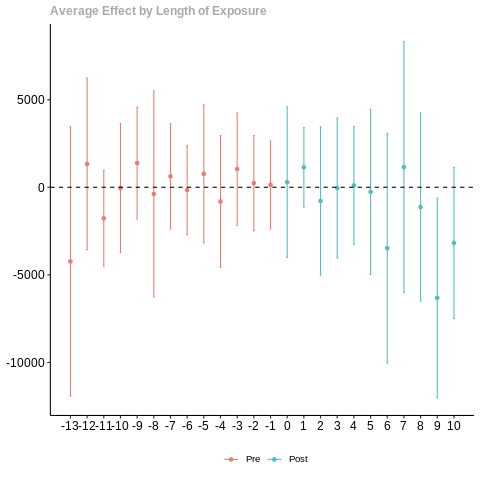

In [170]:
%%R
ggdid(es)

In [171]:
%%R
group_effects <- aggte(out, type = "group", na.rm = TRUE)
summary(group_effects)


Call:
aggte(MP = out, type = "group", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on group/cohort aggregation:  
      ATT    Std. Error     [ 95%  Conf. Int.] 
 688.8494       679.539  -643.0226    2020.721 


Group Effects:
 Group   Estimate Std. Error [95% Simult.  Conf. Band]  
  2009 -3395.0399   1305.734     -6416.341   -373.7389 *
  2011  2646.7119   1917.333     -1789.750   7083.1734  
  2012  2472.0217   3745.385     -6194.318  11138.3614  
  2013 -3898.2174   1238.930     -6764.942  -1031.4930 *
  2014   909.8255   1432.392     -2404.545   4224.1963  
  2015  1268.8416   2784.449     -5174.015   7711.6984  
  2016   274.4397   1320.524     -2781.082   3329.9611  
  2017  1818.2989   1286.605     -1158.740   4795.3375 

#Random forest prediction with feature significance

In [172]:
#just experient with csa_cases
#other ways to do this https://mljar.com/blog/feature-importance-in-random-forest/
#https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [173]:
# define dataset
y = df['sub_csa_cases']
X = df[["post",'Screening', 'Criminalization', 'Task_Force', 'Posters']] #'popwt', 'median_household_income', 'Unemployment_rate', 'Required', 'Some_All_Staff','Opt_Out', 'PK_5', '6_12'

In [174]:
labs = X.columns.tolist()

In [175]:
cur = [i for i in range(0,len(labs))]

In [176]:
#https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem

# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)

#plt.xticks(cur,labs)
plt.show()

Feature: 0, Score: 0.21719
Feature: 1, Score: 0.16432
Feature: 2, Score: 0.21911
Feature: 3, Score: 0.20632
Feature: 4, Score: 0.19307


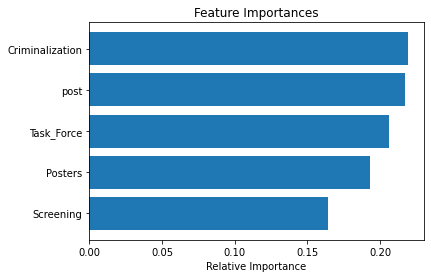

In [177]:
features = labs
indices = np.argsort(importance)

ind =[]
r2 = 0
for n in indices:
  ind.append(r2)
  r2+=1

plt.title('Feature Importances')
plt.barh(ind, importance[indices], align='center') #color='b',
plt.yticks(ind, [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#Causal random forest

##Causal random forest variable selection

In [178]:
# set variables 
treatment = 'post'
outcome = 'sub_csa_cases'
covariates = ['Screening', 'Criminalization',  'Task_Force', 'Posters', 'median_household_income', 'Unemployment_rate', 'pop'] 

##Causal dataframe creation

In [179]:
selected_columns = df[["sid","sub_csa_cases", 'post', 'year', 'Screening', 'Criminalization',  'Task_Force', 'Posters', 'median_household_income', 'sub_ca_cases', 'sub_rep_csa_ratio', 'rep_csa_cases','Unemployment_rate', 'sub_csa_yc', 'sub_ca_yc', 'pop', 'rep_csa_inc']] #'Effective_Date'
df_ml = selected_columns.copy()

In [180]:
#convert the values to integers
df_ml['Unemployment_rate'] = df_ml['Unemployment_rate'].apply(lambda x : x * 100)
df_ml['pop'] = df_ml['pop'].apply(lambda x : x / 10000)
df_ml['median_household_income'] = df_ml['median_household_income'].apply(lambda x : x / 100)
df_ml['sub_rep_csa_ratio'] = df_ml['sub_rep_csa_ratio'].apply(lambda x : x * 1000)
df_ml = df_ml.round(0)
df_ml = df_ml.astype(int) 

In [181]:
df_ml.head()

sid  sub_csa_cases  post  year  Screening  Criminalization  Task_Force  \
0    0            931     0  2005          0                0           0   
1    0           5262     0  2006          0                0           0   
2    0           6061     0  2007          0                0           0   
3    0           5210     0  2008          0                0           0   
4    0           3875     0  2009          0                0           0   

   Posters  median_household_income  sub_ca_cases  sub_rep_csa_ratio  \
0        0                      372         37514              58904   
1        0                      380         97098               3132   
2        0                      422          7100                987   
3        0                      445        109084               8866   
4        0                      400         10962              10955   

   rep_csa_cases  Unemployment_rate  sub_csa_yc  sub_ca_yc  pop  rep_csa_inc  
0          54840                450           0          0  457            4  
1          16480                400          -5         -2  463           27  
2           5980                400           0          1  467           26  
3          46194                570           0        -14  472            4  
4          42452               1100           0          1  476           14

In [182]:
# split data into train and test sets 
train, test = train_test_split(df_ml, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

##Model visualization

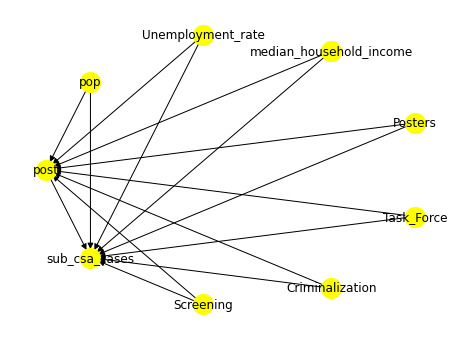

In [183]:
# build causal graph with dowhy 
model = CausalModel(
    data=df_ml,
    treatment=treatment, 
    outcome=outcome, 
    common_causes=covariates, 
    instruments=None, 
    effect_modifiers=None)
model.view_model()

##Model selection

In [184]:
#https://econml.azurewebsites.net/spec/estimation/dml.html#dmluserguide
#https://econml.azurewebsites.net/_autosummary/econml.dml.LinearDML.html
#https://github.com/microsoft/EconML/blob/master/notebooks/Double%20Machine%20Learning%20Examples.ipynb
#https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html

According to the documentation, double Machine Learning is a method for estimating (heterogeneous) treatment effects when all potential confounders/controls (factors that simultaneously had a direct effect on the treatment decision in the collected data and the observed outcome) are observed, but are either too many (high-dimensional) for classical statistical approaches to be applicable or their effect on the treatment and outcome cannot be satisfactorily modeled by parametric functions (non-parametric). Both of these latter problems can be addressed via machine learning techniques (see e.g. [Chernozhukov2016]).

The method reduces the problem to first estimating two predictive tasks:

predicting the outcome from the controls,

predicting the treatment from the controls;

Then the method combines these two predictive models in a final stage estimation so as to create a model of the heterogeneous treatment efffect. The approach allows for arbitrary Machine Learning algorithms to be used for the two predictive tasks, while maintaining many favorable statistical properties related to the final model (e.g. small mean squared error, asymptotic normality, construction of confidence intervals).

In [185]:
#this test helps select the model among three before tuning it

est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestClassifier(min_samples_leaf=10),
                discrete_treatment=True,
                linear_first_stages=False,
                cv=6)
est.fit(Y, T, X=X, W=W)
te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)


from sklearn.ensemble import GradientBoostingRegressor
est2 = NonParamDML(model_y=GradientBoostingRegressor(),
                  model_t=GradientBoostingRegressor(),
                  model_final=GradientBoostingRegressor())
est2.fit(Y, T, X=X, W=W)
te_pred2 = est2.effect(X_test)
#point = est2.effect(X, T0=t0, T1=t1)


est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       n_estimators=1000,
                       min_impurity_decrease=0.001,
                       verbose=0,
                       cv=6)
est3.tune(Y, T, X=X, W=W)
est3.fit(Y, T, X=X, W=W)
te_pred3 = est3.effect(X_test)
lb3, ub3 = est3.effect_interval(X_test, alpha=0.01)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/s

In [186]:
#lower is better, so model 3 is the best
est.score_

In [187]:
est.ate_inference(X_test)

In [188]:
est2.score_

In [189]:
est2.ate_inference(X_test)

/usr/local/lib/python3.7/dist-packages/econml/inference/_inference.py:148: UserWarning:

Final model doesn't have a `prediction_stderr` method, only point estimates will be returned.

/usr/local/lib/python3.7/dist-packages/econml/inference/_inference.py:148: UserWarning:

Final model doesn't have a `prediction_stderr` method, only point estimates will be returned.



In [190]:
est3.score_

In [191]:
est3.ate_inference(X_test)

##Visualizations of models

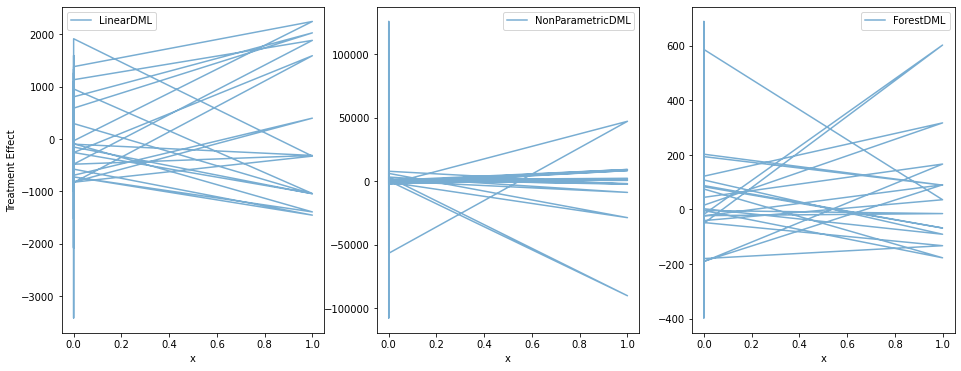

In [192]:
%matplotlib inline
#visualizing the three models
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.plot(X_test.iloc[:, 0], te_pred, label='LinearDML', alpha=.6)
#plt.fill_between(X_test.iloc[:, 0], lb, ub, alpha=.4)

plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(X_test.iloc[:, 0], te_pred2, label='NonParametricDML', alpha=.6)
#plt.fill_between(X_test.iloc[:, 0], lb2, ub2, alpha=.4)

#plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(X_test.iloc[:, 0], te_pred3, label='ForestDML', alpha=.6)
#plt.fill_between(X_test.iloc[:, 0], lb3, ub3, alpha=.4)

#plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

In [193]:
#intrepretation of the model
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2)
intrp.interpret(est, X)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but FunctionTransformer was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but FunctionTransformer was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but FunctionTransformer was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but FunctionTransformer was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but FunctionTransformer was fitted without feature names

/usr/local/lib/python

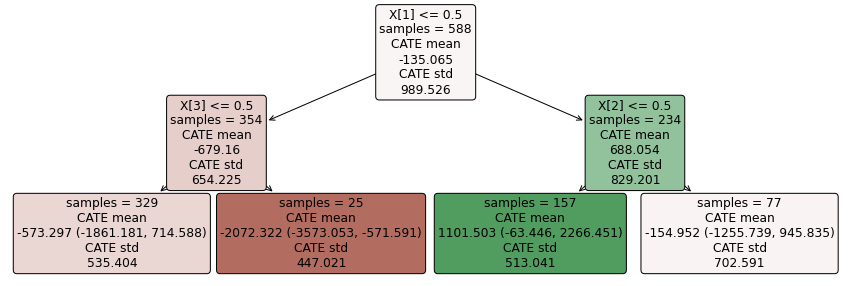

In [194]:
plt.figure(figsize=(15, 5))
intrp.plot()
plt.show()

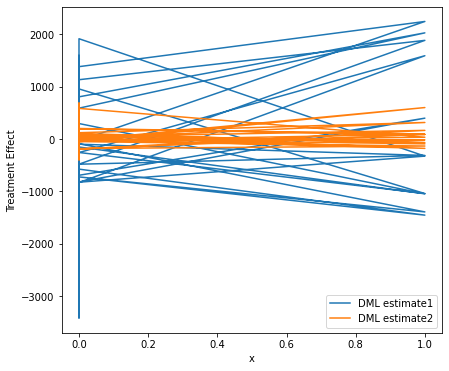

In [195]:
#performance visualization
#https://github.com/microsoft/EconML/blob/master/notebooks/Double%20Machine%20Learning%20Examples.ipynb

te_pred = est.const_marginal_effect(X_test)
lb, ub = est.const_marginal_effect_interval(X_test, alpha=0.01)

te_pred2 = est3.const_marginal_effect(X_test)
lb2, ub2 = est3.const_marginal_effect_interval(X_test, alpha=0.01)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

plt.plot(X_test.iloc[:, 0], te_pred[:], label='DML estimate1')
#plt.fill_between(X_test.iloc[:, 0], lb[:], ub[:], alpha=.4)
plt.plot(X_test.iloc[:, 0], te_pred2[:], label='DML estimate2')
#plt.fill_between(X_test.iloc[:, 0], lb2[:], ub2[:], alpha=.4)

plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()

plt.show()

##Hyperparameter tuning 

###Grid search

We ran the following test, but it takes about an hour, so we converted it now to markdown text to avoid slowing the notebook

this is for tuning the model
https://econml.azurewebsites.net/spec/estimation/dml.html
from econml.dml import NonParamDML
from sklearn.model_selection import GridSearchCV
cv_reg = lambda: GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid={
                    'max_depth': [3, None],
                    'n_estimators': (10, 30, 50, 100, 200, 400, 600, 800, 1000),
                    'max_features': (1,2,3)
                }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
            )
est4 = NonParamDML(model_y=cv_reg(), model_t=cv_reg(), model_final=cv_reg())

est4.fit(Y, T, X=X, W=W)

est4.ate_inference(X_test)

not as good as model 3 --did horribly 1165385.59736407
est4.score_

###Grid search as two stages

In [196]:
#manual method for two stage ML tuning
first_stage = lambda: GridSearchCV(
                estimator=RandomForestRegressor(),
                param_grid={
                        'max_depth': [3, None],
                        'n_estimators': (10, 30, 50, 100, 200),
                        'max_features': (1,2,3)
                    }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
                )
model_y = first_stage().fit(X, Y).best_estimator_
model_t = first_stage().fit(X, T).best_estimator_
est5 = LinearDML(model_y=model_y, model_t=model_t)

In [197]:
est5.fit(Y, T, X=X, W=W)

In [198]:
est5.ate_inference(X_test)

In [199]:
#not as good as model 3 but the p value above is quite good
est5.score_

###Parameters selected

In [200]:
# set parameters for causal forest 
#taken from https://towardsdatascience.com/causal-machine-learning-for-econometrics-causal-forests-5ab3aec825a7
causal_forest = CausalForestDML(criterion='het', #'het' -- 5727 and 'mse' -- 8194--average change in CSA per state
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(), 
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest.const_marginal_ate(X_test)

##Alternate simple model (sub_csa_cases)

In [201]:
#first use on sub_csa_cases
#example from documentation
#https://econml.azurewebsites.net/spec/interpretability.html
est_alt = LinearDML()
est_alt.fit(Y, T, X=X, W=W)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to it

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but FunctionTransformer was fitted without feature names



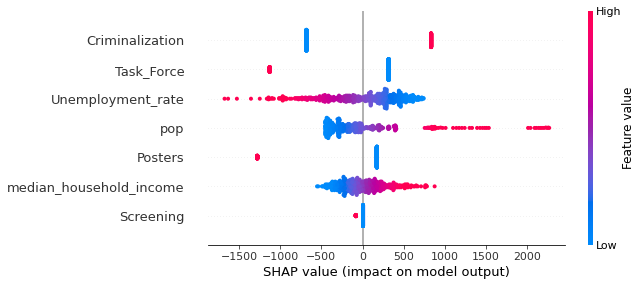

In [202]:
shap_values_alt = est_alt.shap_values(X)

# global view: explain hetergoeneity for a sample of dataset
shap.summary_plot(shap_values_alt['sub_csa_cases']['post'])

In [203]:
est_alt.const_marginal_ate(X_test)

In [204]:
est_alt.ate_inference(X_test)

In [205]:
#not as good as est3 in terms of score
est_alt.score_

##y = sub_csa_cases

In [206]:
# set parameters for causal forest 
#taken from https://towardsdatascience.com/causal-machine-learning-for-econometrics-causal-forests-5ab3aec825a7
causal_forest = CausalForestDML(criterion='het', #'het' -- 5727 and 'mse' -- 8194--average change in CSA per state
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest.const_marginal_ate(X_test)

In [207]:
#https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html
#https://arxiv.org/pdf/2104.09935.pdf
#causal_forest.ate(X_test)

In [208]:
causal_forest.ate_inference(X_test)

###Interpret the model

In [209]:
# fit causal forest with default parameters because apparently runmning this with the above tailored model takes a long time
#here is the documentation https://econml.azurewebsites.net/spec/interpretability.html

# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X.astype(float))


100%|===================| 586/588 [03:02<00:00]       

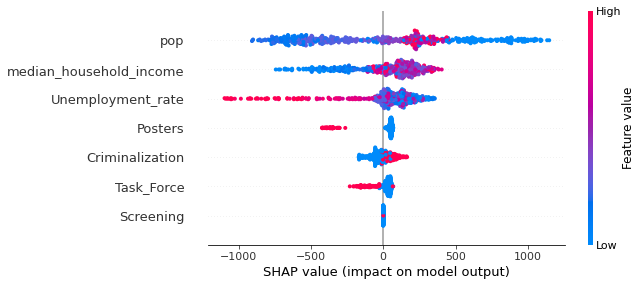

In [210]:
# plot shap values 
shap.summary_plot(shap_values['sub_csa_cases']['post'])

In [211]:
# calculate shap values of causal forest model 
#see also https://github.com/microsoft/EconML/issues/464
#https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d


###Model visualization of uncertainty

In [212]:
#this starts with the default causal_forest from the prior cell--not the more tailored one

# use causal forest model to estimate treatment effects  
treatment_effects = causal_forest.effect(X)
# calculate lower bound and upper bound confidence intervals 
lb, ub = causal_forest.effect_interval(X, alpha=0.05)

# convert arrays to pandas dataframes for plotting
te_df = pd.DataFrame(treatment_effects, columns=['cate']) # or 'ate' based on mse error
lb_df = pd.DataFrame(lb, columns=['lb'])
ub_df = pd.DataFrame(ub, columns=['ub'])

# merge dataframes and sort 
df1 = te_df.merge(lb_df, left_on=te_df.index, right_on=lb_df.index, how='left')
df1.drop(columns=['key_0'], inplace=True)
df1 = df1.merge(ub_df, left_on=df1.index, right_on=ub_df.index, how='left')
df1.drop(columns=['key_0'], inplace=True)
df1.sort_values('cate', inplace=True, ascending=True)
df1.reset_index(inplace=True, drop=True)

# calculate rolling mean
z = df1.rolling(window=30, center=True).mean()

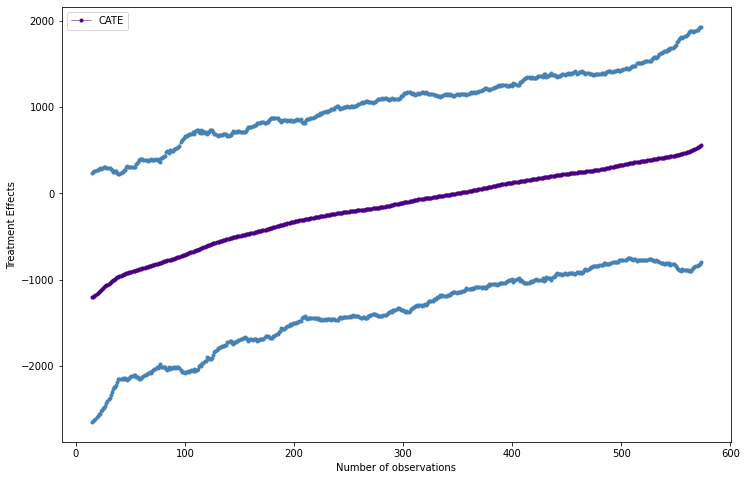

In [213]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))
# plot lines for treatment effects and confidence intervals
ax.plot(z['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(z['lb'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
ax.plot(z['ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

##y = sub_rep_csa_ratio

In [214]:
causal_forest_ratio = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_ratio.fit(train['sub_rep_csa_ratio'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_ratio.const_marginal_ate(X_test)

In [215]:
causal_forest_ratio.ate_inference(X_test)

In [216]:
causal_forest_ratio_alt = LinearDML()
causal_forest_ratio_alt.fit(train['sub_rep_csa_ratio'], T, X=X, W=W)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to it

In [217]:
causal_forest_ratio_alt.ate_inference(X_test)

##y = rep_csa_cases

In [218]:
causal_forest_reported = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(), 
                                )

causal_forest_reported.fit(train['rep_csa_cases'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_reported.const_marginal_ate(X_test)

In [219]:
causal_forest_reported.ate_inference(X_test)

In [220]:
causal_forest_reported_alt = LinearDML()
causal_forest_reported_alt.fit(train['rep_csa_cases'], T, X=X, W=W)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to it

In [221]:
causal_forest_reported_alt.ate_inference(X_test)

##y = sub_ca_cases

In [222]:
causal_forest_all = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_all.fit(train['sub_ca_cases'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_all.const_marginal_ate(X_test)

In [223]:
causal_forest_all.ate_inference(X_test)

##y = sub_csa_yc

In [224]:
causal_forest_car = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_car.fit(train['sub_csa_yc'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_car.const_marginal_ate(X_test)

In [225]:
causal_forest_car.ate_inference(X_test)

##y = sub_ca_yc


In [226]:
causal_forest_rar = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_rar.fit(train['sub_ca_yc'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_rar.const_marginal_ate(X_test)

In [227]:
causal_forest_rar.ate_inference(X_test)

##y = rep_csa_inc

In [228]:
causal_forest_inc = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_inc.fit(train['rep_csa_inc'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_inc.const_marginal_ate(X_test)

In [229]:
causal_forest_inc.ate_inference(X_test)

#Borusyak, Jaravel and Speiss (2021) estimator 

In [230]:
#https://arxiv.org/abs/2108.12419
#https://rdrr.io/cran/didimputation/man/did_imputation.html
#https://cran.r-project.org/web/packages/didimputation/index.html
#https://cran.r-project.org/web/packages/didimputation/readme/README.html
#https://causalinf.substack.com/p/deja-vu-and-differential-timing

##y = sub_csa_cases

In [231]:
#substantiated CSA first
%%R
# Static
static <- did_imputation(data = R_df, yname = "sub_csa_cases", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

static

# A tibble: 1 × 5
  term  estimate std.error conf.low conf.high
  <chr>    <dbl>     <dbl>    <dbl>     <dbl>
1 treat     266.      516.    -744.     1277.


##y = rep_csa_cases

In [232]:
%%R
# Static
staticr <- did_imputation(data = R_df, yname = "rep_csa_cases", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

staticr

# A tibble: 1 × 5
  term  estimate std.error conf.low conf.high
  <chr>    <dbl>     <dbl>    <dbl>     <dbl>
1 treat   -2420.     3195.   -8681.     3842.


##y = sub_rep_csa_ratio

In [233]:
%%R
# Static
staticratio <- did_imputation(data = R_df, yname = "sub_rep_csa_ratio", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

staticratio

# A tibble: 1 × 5
  term  estimate std.error conf.low conf.high
  <chr>    <dbl>     <dbl>    <dbl>     <dbl>
1 treat    -9.40      29.9    -68.1      49.3


##y = rep_csa_inc

In [234]:
%%R
# Static
staticinc <- did_imputation(data = R_df, yname = "rep_csa_inc", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

staticinc

# A tibble: 1 × 5
  term  estimate std.error conf.low conf.high
  <chr>    <dbl>     <dbl>    <dbl>     <dbl>
1 treat     3.95      1.62    0.770      7.13


##y = sub_ca_cases

In [235]:
%%R
# Static
staticsca <- did_imputation(data = R_df, yname = "sub_ca_cases", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

staticsca

# A tibble: 1 × 5
  term  estimate std.error conf.low conf.high
  <chr>    <dbl>     <dbl>    <dbl>     <dbl>
1 treat    7971.     8487.   -8664.    24606.


##Event study for substantiated cases

In [236]:
%%R
esbjs <- did_imputation(data = R_df, yname = "sub_csa_cases", gname = "Effective_Date", tname = "year", idname = "sid", 
               # event-study
               horizon=TRUE, pretrends = -5:-1)

esbjs

# A tibble: 16 × 5
   term  estimate std.error conf.low conf.high
   <chr>    <dbl>     <dbl>    <dbl>     <dbl>
 1 -5        85.0      528.    -950.   1120.  
 2 -4      -335.       620.   -1549.    880.  
 3 -3      -192.       479.   -1131.    747.  
 4 -2      -602.       602.   -1782.    578.  
 5 -1     -1341.       681.   -2676.     -6.19
 6 0        196.       399.    -586.    978.  
 7 1       -390.       515.   -1399.    619.  
 8 2       -213.       574.   -1339.    913.  
 9 3        -84.6      661.   -1381.   1212.  
10 4       -843.       750.   -2312.    626.  
11 5         74.9      807.   -1507.   1656.  
12 6      -1787.       696.   -3151.   -424.  
13 7       1712.       710.     320.   3103.  
14 8        818.       634.    -425.   2060.  
15 9      -2847.       813.   -4440.  -1254.  
16 10      -634.      1004.   -2602.   1333.  


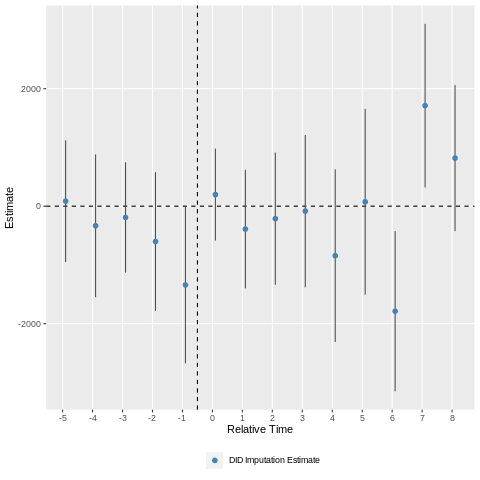

In [237]:
%%R
pts <- esbjs %>%
    select(rel_year = term, estimate, std.error) %>%
    mutate(
        ci_lower = estimate - 1.96 * std.error,
        ci_upper = estimate + 1.96 * std.error,
        group = "DID Imputation Estimate",
        rel_year = as.numeric(rel_year)
    ) %>%
    filter(rel_year >= -8 & rel_year <= 8) %>% 
    mutate(rel_year = rel_year + 0.1)

max_y <- max(pts$estimate)

ggplot() +
    # 0 effect
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_vline(xintercept = -0.5, linetype = "dashed") +
    # Confidence Intervals
    geom_linerange(data = pts, mapping = aes(x = rel_year, ymin = ci_lower, ymax = ci_upper), color = "grey30") +
    # Estimates
    geom_point(data = pts, mapping = aes(x = rel_year, y = estimate, color = group), size = 2) +

    scale_x_continuous(breaks = -8:8, minor_breaks = NULL) +
    scale_y_continuous(minor_breaks = NULL) +
    scale_color_manual(values = c("DID Imputation Estimate" = "steelblue")) +
    labs(x = "Relative Time", y = "Estimate", color = NULL, title = NULL) +

    theme(legend.position = "bottom")

#Social media analytics--insufficient data

We inlcude the below code so you can see what we did, but we are not including the data because it was a dry well and we did not use it in our final analysis

!pip3 install --upgrade tweepy==4.1.0

import json
import pandas as pd
import numpy as np
from getpass import getpass
import tweepy
from datetime import datetime
from dateutil.parser import parse
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS 
import re


In [238]:
#twitter keys
twitter_api_key = getpass('Twitter API Key: ')
twitter_api_secret = getpass('Twitter API Secret: ')

# Pull tweets from twitter related to erin's law
auth = tweepy.AppAuthHandler(twitter_api_key, twitter_api_secret)
twitter_api = tweepy.API(auth)

def query_date(year, month, day):
    return f'{year}{month:02}{day:02}0000'

environment_label = 'test'

query = '#erinslaw OR "erin\'s law"' 

tweets = []
for tweet in tweepy.Cursor(
    twitter_api.search_full_archive,
    label=environment_label,
    query=query,
    fromDate=query_date(year=2010, month=1, day=1),
    toDate=query_date(year=2019, month=12, day=31),
    maxResults=500,
).items():
    tweets.append(tweet)

print(f'Retrieved {len(tweets)} tweets')

# Serialize the tweets and save in json 
serializable_tweets = [
    tweet._json
    for tweet in tweets
]

with open("erintweets.json", "w") as output_file:
    json.dump(serializable_tweets, output_file)

# Open newly created file as dataframe
with open("erintweets.json") as json_file:
        tweets = json.load(json_file)

tweets_df = pd.json_normalize(tweets)

NameError: ignored

In [ ]:
# Created a smaller dataframe just looking at the hashtags for #Erinslaw to look at the data

hashtag_options = ['erinslaw', 'erinlaw', 'jennaslaw', 'jennalaw', 'taraslaw', 'taralaw']

hashtag_df = tweets_df[['created_at', 'id', 'user.screen_name', 'text', 'entities.hashtags']].copy()
hashtag_df = hashtag_df.explode('entities.hashtags')
hashtag_df.dropna(subset=['entities.hashtags'], inplace=True)
hashtag_df['hashtag'] = hashtag_df['entities.hashtags'].apply(lambda tweet: tweet['text'])
hashtag_df['hashtag'] = hashtag_df['hashtag'].str.lower()
hashtag_df = hashtag_df.loc[hashtag_df['hashtag'].isin(hashtag_options)]

# From looking at this dataframe I was able to confirm the originals are in the dataset so we can drop retweets
# also confirmed that Erin herself accounts for about 90% of the tweets I pulled because she put the hashtag in her bio
# so I effectively pulled all of her tweets she's ever made - need to drop her

# Drop Erin from the dataframe
hashtag_df = hashtag_df[hashtag_df['user.screen_name'] != 'ErinMerryn']

# Drop retweets
hashtag_df['RT'] = hashtag_df['text'].str.split(' ').str[0]
hashtag_df = hashtag_df[hashtag_df['RT'] != 'RT']

In [ ]:
CUSTOM_STOP_WORDS = STOPWORDS.union(set(['www','tinyurl', 'com', 'https', 'http', '&amp', 'bit', 'ly', 'bitly']))

# Convert created_at column to datetime and sort by date
tweets_df['Mycol'] = tweets_df['created_at'].apply(parse)
tweets_df['just_date'] = pd.to_datetime(tweets_df['Mycol']).dt.date
tweets_df = tweets_df.sort_values(by=['just_date'], ascending=False)

# drop Erin from the dataframe ErinMerryn
tweets_df = tweets_df[tweets_df['user.screen_name'] != 'ErinMerryn']

# Convert user.name and user.description to strings then preprocess the strings to pull tokens
tweets_df['user.name'] = tweets_df['user.name'].astype(str)
tweets_df['user.description'] = tweets_df['user.description'].astype(str)

tweets_df['name_tokens'] = tweets_df['user.name'].apply(preprocess_string)
tweets_df['user_tokens'] = tweets_df['user.description'].apply(preprocess_string)

tweets_df['name_tokens'] = tweets_df['name_tokens'].apply(
    lambda text: [
        word for word in text
        if word not in CUSTOM_STOP_WORDS
    ]
)

tweets_df['user_tokens'] = tweets_df['user_tokens'].apply(
    lambda text: [
        word for word in text
        if word not in CUSTOM_STOP_WORDS
    ]
)
# Drop retweets
tweets_df['RT'] = tweets_df['text'].str.split(' ').str[0]
tweets_df = tweets_df[tweets_df['RT'] != 'RT']

# Use a regular expression to strip tokens down to just words
# example School123 is now just school
term_regex = re.compile(r"^[^a-z]*(?P<term>[a-z]+(\-[a-z]+)?)([^a-z]*|'s)$", re.I)

def stem_token(token):
    match = term_regex.match(token)
    if not match:
        return ''
    
    return match.group('term')

# Create another column where the user name and descriptions are simply split on spaces
# This is because words like education, and educator get processed down to just educ
tweets_df['name_split'] = tweets_df['user.name'].str.split()
tweets_df['name_split'] = tweets_df['name_split'].apply(lambda x: [w.lower() for w in x])
tweets_df['name_split'] = tweets_df['name_split'].apply(
    lambda x: [stem_token(w) for w in x],
)

tweets_df['decsription_split'] = tweets_df['user.description'].str.split()
tweets_df['decsription_split'] = tweets_df['decsription_split'].apply(lambda x: [w.lower() for w in x])
tweets_df['decsription_split'] = tweets_df['decsription_split'].apply(lambda x: [stem_token(w) for w in x])

# Created a list of occupations/names to help identify tweets by schools and/or faculty
user_name_list = {'school', 'academy', 'elementary', 'high', 'schools'}
user_name_token_list = {'school', 'academi', 'elementari', 'high'}
user_description_list = {'educator', 'principal', 'librarian', 'teacher', 'superintendent', 'counselor'}
user_token_description_list = {'educ', 'princip', 'librarian', 'teacher', 'superintend', 'counselor'}

# Used the tokens and the above split words to look for words I may have missed 
tweets_df['token_name_matches'] = tweets_df['name_tokens'].apply(lambda name_tokens: len(set(name_tokens).intersection(user_name_token_list)) > 0)
tweets_df['name_matches'] = tweets_df['name_split'].apply(lambda name_split: len(set(name_split).intersection(user_name_list)) > 0)

tweets_df['description_token_matches'] = tweets_df['user_tokens'].apply(lambda user_tokens: len(set(user_tokens).intersection(user_token_description_list)) > 0)
tweets_df['description_matches'] = tweets_df['decsription_split'].apply(lambda decsription_split: len(set(decsription_split).intersection(user_description_list)) > 0)

# Only keep the tweets where the name matches words from the name list OR the description contains at least 1 word
# from the above description list
tweets_df = tweets_df.loc[(tweets_df['name_matches'] == True) | (tweets_df['description_matches'] == True)]

# Drop rows where location info is missing for both user location and derived location
drop_df = tweets_df.copy()
drop_df['user.derived.locations'] = drop_df['user.derived.locations'].fillna(0)
drop_df['user.location'] = drop_df['user.location'].fillna(0)

drop_df = drop_df.loc[(drop_df['user.location'] == 0) & (drop_df['user.derived.locations'] == 0)]
drop_df_list = list(drop_df['id'])
drop_df_list

tweets_df = tweets_df[~tweets_df.id.isin(drop_df_list)]

# Use the user.derived.locations column to create a region column that contains the state the tweet was from
def guess_location(derived_location):
    if isinstance(derived_location, float):
        return derived_location

    for location in derived_location:
        if 'region' in location and location['region']:
            return location['region']

    return np.nan

tweets_df['region'] = tweets_df['user.derived.locations'].apply(guess_location)

# Look at the regions to get a feel for distribution of remaining tweets
print(tweets_df.region.value_counts())

# From looking at the regions a few tweets are from other countries. I manually looked up the respecitve tweets and 
# determined they were not relevant and dropped them
drop_locations = ['Scotland', 'Ontario', 'British Columbia']
tweets_df = tweets_df[~tweets_df['region'].isin(drop_locations)]

# There is still a lot of variation in the kept tweets (teacher tweeting about law passing not about education) or
# schools tweeting asking followers to go vote on the issue

# Original pulled tweets dataframe was about 25K tweets, and after all of the above processing and filtering the remaining 
# dataframe is just under 400 tweets long. I manually went through each of these remaining tweets to assess the 
# relevance of the tweet and if it should be kept or not

# Index #'s to drop after manual inspection of remaining tweets
index_drop = [1038, 1563, 1697, 2008, 2142, 2103, 2415, 2945, 3273, 3344, 3576,
              4099, 4120, 4180, 4179, 4172, 4193, 4231, 4245, 4529, 4565, 4549,
              4764, 5088, 5093, 5216, 5529, 5658, 5677, 5676, 5765, 5827, 5843, 
              6140, 6145, 6156, 6155, 6154, 6638, 6655, 6666, 6663, 6658, 6661,
              6757, 6773, 6796, 6801, 6799, 6805, 6806, 6808, 6829, 7989, 7995,
              8165, 8221, 8617, 8659, 8693, 8831, 9840, 10497, 10515, 11087,
              11836, 11999, 12012, 12023, 12029, 12085, 12491, 12482, 12707,
              12746, 12772, 12795, 12798, 12799, 12829, 12833, 12897, 13373,
              13431, 13936, 14238, 14290, 14309, 14342, 14339, 14340, 14346,
              14733, 14746, 15167, 15674, 15908, 15936, 16026, 16013, 16293,
              16298, 16316, 16629, 17121, 17136, 17336, 17335, 17727, 17851,
              17839, 18239, 21135, 23316]

print(len(index_drop)) # 114

# drop the tweets from the main dataframe
tweets_df = tweets_df.drop(index_drop)

# Lets look at what states are left given our 200 remaining tweets
print(tweets_df.region.value_counts())


Illinois          116

Alabama            20

Tennessee           8

South Carolina      7

Oregon              5

Kansas              3

Connecticut         1

Georgia             1

Name: region, dtype: int64

In [ ]:
# Can look at a visual of remain tweets
ax = tweets_df.region.value_counts().plot(kind='bar')
ax.set_title('Tweets by State')

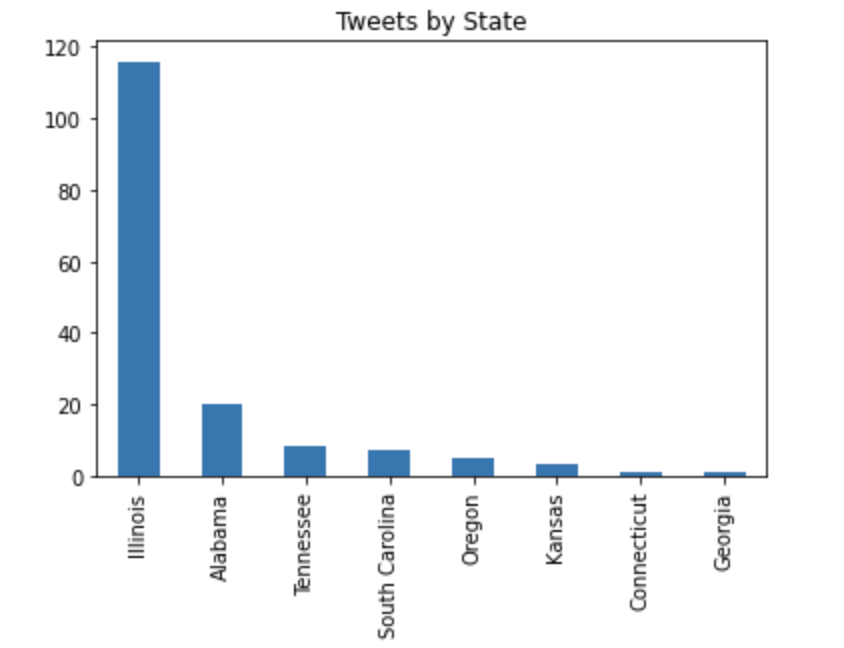